# Proyecto Open Data I
## Radares, y su eficiencia en la CAM
### Recopilación, limpieza y tratamiento de los datos
Este cuaderno pretende enseñar el proceso de limpieza de los datos relativos a los radares en la CAM
_Paula Gómez Lucas, Alejandro Majado Martínez_

In [1]:
# Importar librerías
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
from pandas_summary import DataFrameSummary
import textwrap
import utm

from scipy.stats import chisquare, zscore

A continuación, se muestra la clase que está compuesta de todos los métodos que se encargan de la limpieza y transformación de los datos

In [2]:
class CSVDataLoader:
    """
    A class for loading and cleaning CSV data from a specified folder path.

    Attributes:
    -----------
    folder_path : str
        The path to the folder containing the CSV files to be loaded.

    data : dict
        A dictionary containing the loaded CSV data, where the keys are the file names and the values are the corresponding dataframes.
    """

    def __init__(self, folder_path):
        """
        Initializes a CSVDataLoader object with the specified folder path.

        Parameters:
        -----------
        folder_path : str
            The path to the folder containing the CSV files to be loaded.
        """
        self.folder_path = folder_path
        self.data = {}
        self.filename = []
        self.keys = []

    def load_data(self):
        """
        Loads CSV data from the specified folder path into a dictionary.

        Returns:
        --------
        None
        """
        csv_files = [f for f in os.listdir(self.folder_path) if f.endswith('.csv')]
        folders = ("datasets/actuacionesBomberos", "datasets/estaciones", "datasets/accidentalidad")
        for folder in folders:
            df = None
            for file in os.listdir(folder):
                filepath = folder + "/" + file
                df1 = pd.read_csv(filepath, sep=';', encoding='utf-8', low_memory=False)
                df = pd.concat([df, df1])
            self.data[str(folder)] = df

        for file_name in csv_files:
            file_path = os.path.join(self.folder_path, file_name)
            try:
                if file_name == 'iluminacion.csv':
                    df = pd.read_csv(file_path, sep=',', encoding='utf-8', low_memory=False, decimal=".")
                else:
                    df = pd.read_csv(file_path, sep=';', encoding='latin-1', low_memory=False, decimal=",")
                self.data[str(file_name)] = df
                self.filename.append(file_name)
            except Exception as e:
                print(f"Error al leer {file_name}: {str(e)}")

        for value in self.data.keys():
            self.keys.append(value)

    def clean_data(self):
        """
        Cleans the loaded CSV data by renaming columns, removing whitespace, dropping null values and duplicates, and converting date columns to datetime format.

        Returns:
        --------
        None
        """
        columna_borrar = "Unnamed"
        for df in self.data:
            for j in self.data[df].columns:
                if columna_borrar in j:
                    while j in self.data[df].columns:
                        self.data[df] = self.data[df].drop(j, axis=1)
                        self.data[df] = self.data[df].dropna(how='all', axis=0)
                        
            self.data[df] = self.data[df].rename(columns = lambda x: x.strip().lower().replace(' ', '_'))
            self.data[df] = self.data[df].map(lambda x: x.strip() if isinstance(x, str) else x)
            self.data[df] = self.data[df].dropna(how='all', axis=0)
            self.data[df] = self.data[df].drop_duplicates()
            self.data[df] = self.data[df].loc[:, ~self.data[df].columns.duplicated()]
            self.data[df].columns = map(str.upper, self.data[df].columns)

            if 'FECHA' in self.data[df].columns:
                self.data[df]['FECHA'] = pd.to_datetime(self.data[df]['FECHA'], format='%d/%m/%Y')

#           num_cols = self.data[i].select_dtypes(include='number').columns
#           for col in num_cols:
#               self.data[i][col] = self.data[i][col].fillna(self.data[i][col].mean())

    def get_info(self, filename):
        print(self.data[filename].isnull().sum())
        print(self.data[filename].info())
        
    def get_nan_columns(self):
        j = 0
        for i in self.data:
            print(self.keys[j])
            self.get_info(i)
            j+=1
      
    def get_cleaned_data(self):
        """
        Returns the cleaned CSV data as a dictionary.

        Returns:
        --------
        dict
            A dictionary containing the cleaned CSV data, where the keys are the file names and the values are the corresponding dataframes.
        """
        return self.data

    def create_graph(df, colummn, name):
        frec = df[''+str(colummn)].value_counts()
        aux_df = pd.DataFrame(frec)
        aux_df.columns = ["Frecuencia absoluta"]
        aux_df["Frecuencia relativa"] = 100*aux_df["Frecuencia absoluta"] / len(df)
        frec_rel_cumsum = aux_df["Frecuencia relativa"].cumsum()
        aux_df["Frecuencia relativa acumulada"] = frec_rel_cumsum
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_title('Distribución de '+ str(name))
        ax.bar(aux_df.index, aux_df['Frecuencia absoluta'], color='blue')
        ax2 = ax.twinx()
        ax2.plot(aux_df.index, aux_df['Frecuencia relativa acumulada'], color='red', marker='o', ms = 5)
        ax2.yaxis.set_major_formatter(PercentFormatter())
        ax.tick_params(axis='y', color = 'blue')
        ax2.tick_params(axis='y', color = 'red')
        ax.set_xticklabels(aux_df.index, rotation=90)
        plt.show()

    def dataframe_summary(self, filename):

        numeric_mask = self.data[filename].select_dtypes(include='number').columns

        # Create a DataFrameSummary object
        summary = DataFrameSummary(self.data[filename][numeric_mask])
    
        # Display summary statistics
        summary_stats = summary.summary()
    
        # Plot correlation matrix for all numeric columns
        self.data[filename][numeric_mask].corr(method='pearson', numeric_only=True)

        # Boxplot of each variable
        #self.data[filename][numeric_mask].boxplot(figsize=(10, 8))

        return summary_stats

Una vez está definida la clase con sus métodos, procedemos a declarar las variables que nos permiten trabajar con ello

In [3]:
folder_path = "datasets"
data_loader = CSVDataLoader(folder_path)

La siguiente función carga los datos de los csv a los dataframes

In [4]:
data_loader.load_data()

Limpiamos los datos eliminando las columnas autogeneradas con NaNs, renombramos las columnas para que sean uniformes (minúsculas y con barra bajas), eliminamos las filas de NaNs, eliminamos las filas duplicadas, formateamos todas las variables fecha para que sean consistentes (dd/mm/aaaa), sustituimos los NaNs de las variables numéricas con la media correspondiente a su variable.

In [5]:
data_loader.clean_data()
data = data_loader.get_cleaned_data()

Por último, para confirmar que los datos se han cargado bien, utilizamos el método get_nan_columns para ver cuántos datos en cada columna quedan nulos, así como usamos el método info() de pandas para ver un resumen de todas las columnas y comprobamos también que todo el formateo de las columnas se ha realizado sin problema.

In [6]:
data_loader.get_nan_columns()

datasets/actuacionesBomberos
AÑO                         0
MES                         0
DISTRITO                    0
FUEGOS                      0
DAÑOS_EN_CONSTRUCCION       0
SALVAMENTOS_Y_RESCATES      0
DAÑOS_POR_AGUA              0
INCIDENTES_DIVERSOS         0
SALIDAS_SIN_INTERVENCION    0
SERVICIOS_VARIOS            0
TOTAL                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 0 to 262
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AÑO                       439 non-null    int64 
 1   MES                       439 non-null    object
 2   DISTRITO                  439 non-null    object
 3   FUEGOS                    439 non-null    int64 
 4   DAÑOS_EN_CONSTRUCCION     439 non-null    int64 
 5   SALVAMENTOS_Y_RESCATES    439 non-null    int64 
 6   DAÑOS_POR_AGUA            439 non-null    int64 
 7   INCIDENTES_DIVERSOS       439 non-nul

Efectivamente, se realiza sin problemas. El siguiente paso es el análisis de los datasets columna a columna para revisar qué método usar para rellenar los datos faltantes dependiendo de cada atributo.  

### Sustitución de valores faltantes
Los datasets actuaciones bomberos y estaciones no tienen datos faltantes, por lo que sólo nos queda trabajar con los otros 8 datasets, que podemos observar aquí:

In [7]:
for i in data.keys():
    print(i)

datasets/actuacionesBomberos
datasets/estaciones
datasets/accidentalidad
calendario.csv
DireccionesVigentes_20231004.csv
DireccionesEvolucionHistorica_20231004.csv
padron22.csv
VialesVigentesDistritosBarrios_20231004.csv
RADARES_FIJOS_vDTT.csv
VialesEvolucionHistorica_20231004.csv
VialesVigentesDistritos_20231004.csv
VialesVigentes_20231004.csv
iluminacion.csv


Empecemos con accidentalidad: 

In [8]:
data_loader.get_info('datasets/accidentalidad')
data_loader.data['datasets/accidentalidad']

NUM_EXPEDIENTE               0
FECHA                        0
HORA                         0
LOCALIZACION                 0
NUMERO                       6
COD_DISTRITO                 6
DISTRITO                     6
TIPO_ACCIDENTE               5
ESTADO_METEOROLÓGICO     20120
TIPO_VEHICULO              816
TIPO_PERSONA                 3
RANGO_EDAD                   0
SEXO                         0
COD_LESIVIDAD            85278
LESIVIDAD                85278
COORDENADA_X_UTM             3
COORDENADA_Y_UTM             3
POSITIVA_ALCOHOL           718
POSITIVA_DROGA          195001
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 51810
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NUM_EXPEDIENTE        195610 non-null  object        
 1   FECHA                 195610 non-null  datetime64[ns]
 2   HORA                  195610 non-null  object       

,NUM_EXPEDIENTE,FECHA,HORA,LOCALIZACION,NUMERO,COD_DISTRITO,DISTRITO,TIPO_ACCIDENTE,ESTADO_METEOROLÓGICO,TIPO_VEHICULO,TIPO_PERSONA,RANGO_EDAD,SEXO,COD_LESIVIDAD,LESIVIDAD,COORDENADA_X_UTM,COORDENADA_Y_UTM,POSITIVA_ALCOHOL,POSITIVA_DROGA
0,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Conductor,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN
1,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN
3,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,NaN
4,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 55 a 59 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,NaN
5,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Turismo,Conductor,De 45 a 49 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51806,2019S039993,2019-11-10,11:00:00,PLAZA. ELIPTICA / CALL. MARCELO USERA,1,12.0,USERA,Colisión lateral,Despejado,Turismo,Pasajero,De 60 a 64 años,Mujer,14.0,Sin asistencia sanitaria,"439115,482","4470746,354",N,NaN
51807,2019S040001,2019-03-13,12:47:00,"CALL. ALFONSO FERNANDEZ CLAUSELLS, 7",7,9.0,MONCLOA-ARAVACA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Desconocido,Desconocido,NaN,NaN,"438541,541","4479292,853",N,NaN
51808,2019S040001,2019-03-13,12:47:00,"CALL. ALFONSO FERNANDEZ CLAUSELLS, 7",7,9.0,MONCLOA-ARAVACA,Choque contra obstáculo fijo,Despejado,Turismo,Conductor,Más de 74 años,Mujer,NaN,NaN,"438541,541","4479292,853",N,NaN
51809,2019S040007,2019-11-03,10:10:00,"CALL. HALCONERO DEL REY, 0",0,11.0,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 25 a 29 años,Mujer,NaN,NaN,"438343,989","4468673,466",N,NaN


Hay algunos datos faltantes que tiene sentido que lo sean, y podemos sustituir por un buzzword de algún tipo que nos haga saber que se trate de esto, como lo es que en un accidente en el que no se han producido lesiones, la lesividad sea nula y tampoco haya código de la misma, y como ambas cifras coinciden, es lógico pensar que se trata de las mismas situaciones. Podemos sustituir entonces todos los NaNs de Lesividad faltantes por 'Se desconoce' y el código por 77.

In [9]:
print(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].unique())

[14.  7. nan  2.  6.  1.  3.  5.  4. 77.]


In [10]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==1)


0        NaN
1        NaN
3        NaN
4        NaN
5        NaN
        ... 
51806    NaN
51807    NaN
51808    NaN
51809    NaN
51810    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [11]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==2)

0        NaN
1        NaN
3        NaN
4        NaN
5        NaN
        ... 
51806    NaN
51807    NaN
51808    NaN
51809    NaN
51810    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [12]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==3)

0        NaN
1        NaN
3        NaN
4        NaN
5        NaN
        ... 
51806    NaN
51807    NaN
51808    NaN
51809    NaN
51810    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [13]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==4)

0        NaN
1        NaN
3        NaN
4        NaN
5        NaN
        ... 
51806    NaN
51807    NaN
51808    NaN
51809    NaN
51810    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [14]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==5)

0        NaN
1        NaN
3        NaN
4        NaN
5        NaN
        ... 
51806    NaN
51807    NaN
51808    NaN
51809    NaN
51810    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [15]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==6)

0        NaN
1        NaN
3        NaN
4        NaN
5        NaN
        ... 
51806    NaN
51807    NaN
51808    NaN
51809    NaN
51810    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [16]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==7)

0                                                      NaN
1                                                      NaN
3        Asistencia sanitaria sólo en el lugar del acci...
4        Asistencia sanitaria sólo en el lugar del acci...
5                                                      NaN
                               ...                        
51806                                                  NaN
51807                                                  NaN
51808                                                  NaN
51809                                                  NaN
51810                                                  NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [17]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==14)

0        Sin asistencia sanitaria
1        Sin asistencia sanitaria
3                             NaN
4                             NaN
5        Sin asistencia sanitaria
                   ...           
51806    Sin asistencia sanitaria
51807                         NaN
51808                         NaN
51809                         NaN
51810                         NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [18]:
data_loader.data['datasets/accidentalidad']['LESIVIDAD'].where(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD']==77)

0        NaN
1        NaN
3        NaN
4        NaN
5        NaN
        ... 
51806    NaN
51807    NaN
51808    NaN
51809    NaN
51810    NaN
Name: LESIVIDAD, Length: 195610, dtype: object

In [19]:
# Mapping dictionary
mapping_dict = {
    1: 'Atención en urgencias sin posterior ingreso',
    2: 'Ingreso inferior o igual a 24 horas',
    3: 'Ingreso superior a 24 horas',
    4: 'Fallecido 24 horas',
    5: 'Asistencia sanitaria ambulatoria con posterioridad',
    6: 'Asistencia sanitaria inmediata en centro de salud o mutua',
    7: 'Asistencia sanitaria sólo en el lugar del accidente',
    14: 'Sin asistencia sanitaria',
    77: 'Se desconoce',
}

# Fill missing values using the mapping dictionary
data_loader.data['datasets/accidentalidad']['LESIVIDAD'] = data_loader.data['datasets/accidentalidad']['LESIVIDAD'].fillna(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].map(mapping_dict))
data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'] = data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].fillna(data_loader.data['datasets/accidentalidad']['LESIVIDAD'].map({v: k for k, v in mapping_dict.items()}))

data_loader.data['datasets/accidentalidad']['LESIVIDAD'].fillna('Se desconoce', inplace=True)
data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].fillna(77, inplace=True)


Por otro lado, positivo en droga tiene valor sólo si daba positivo, por lo que rellenar los valores faltantes con 0 es lo más lógico (siendo 0 negativo en droga). 

In [20]:
data_loader.data['datasets/accidentalidad']['POSITIVA_DROGA'] = data_loader.data['datasets/accidentalidad']['POSITIVA_DROGA'].fillna(0)

Número, código de distrito, tipo de accidente, coordenadas (x e y), son atributos a los que sólo les falta un dato cada uno, por lo que no es representativo esta falta de datos y podemos rellenarlos con el valor más habitual. 

In [21]:
correspondences = data_loader.data['datasets/accidentalidad'].groupby(['COD_DISTRITO', 'DISTRITO']).apply(lambda x: x['NUMERO'].unique())

# Display the correspondences
print(correspondences)

COD_DISTRITO  DISTRITO           
1.0           CENTRO                 [48, 6, 37, 45, 4, 42, 30, 1, 38, 125, 25, 96,...
2.0           ARGANZUELA             [3, 12, 2, 136, 209, 29, 19, 150, 39, 82, 44, ...
3.0           RETIRO                 [60, 1, 77, 119, 39, 28, 32, 8, 71, 2, 7, 226,...
4.0           SALAMANCA              [86, 07NL31, 3, 04NL95, 18, 06NL40, 06NC40, 11...
5.0           CHAMARTÍN              [33, 0, 104, 138, 106, 32NC30, 54, 144, 14, 8,...
6.0           TETUÁN                 [16, 21A, 2, 39, 20, 25, 116, 173, 65, 69, 0, ...
7.0           CHAMBERÍ               [7, 83, 12, 51, 27, 15, 4, 32, 41, 33, 48, 30,...
8.0           FUENCARRAL-EL PARDO    [69, 7A, 29XC60, 86, 15, 50, 20, 1, 0, 144, 32...
9.0           MONCLOA-ARAVACA        [34, 6, 1, 2, 23, 57, 84, 5, 18NC68, 19XC70, +...
10.0          LATINA                 [1, 15, 151, 6, 38, 116, 34, 28, 7, 5, 52, 9, ...
11.0          CARABANCHEL            [4, 3, 63, 54, 98, 1, 150, 12, 118, 43, 42B, 1...
12.0     

In [22]:
columns_to_check = ['COD_DISTRITO', 'DISTRITO']

# Check for missing values in the specified columns
missing_values_rows = data_loader.data['datasets/accidentalidad'][data_loader.data['datasets/accidentalidad'][columns_to_check].isnull().any(axis=1)]

# Display the rows with missing values
print(missing_values_rows)


      NUM_EXPEDIENTE      FECHA      HORA  \
10110    2023S009762 2023-03-16  22:40:00   
27635    2020S016821 2020-11-23   7:45:00   
27636    2020S016821 2020-11-23   7:45:00   
25744    2021S015933 2021-09-11  19:40:00   
25745    2021S015933 2021-09-11  19:40:00   
25746    2021S015933 2021-09-11  19:40:00   

                                            LOCALIZACION NUMERO  COD_DISTRITO  \
10110  GTA. ISIDRO GONZALEZ VELAZQUEZ / CALL. FRANCIS...    NaN           NaN   
27635                       AUTOV. M-23, 0 (0.8 ENTRADA)    NaN           NaN   
27636                       AUTOV. M-23, 0 (0.8 ENTRADA)    NaN           NaN   
25744                         AUTOV. M-500 / AUTOV. M-30    NaN           NaN   
25745                         AUTOV. M-500 / AUTOV. M-30    NaN           NaN   
25746                         AUTOV. M-500 / AUTOV. M-30    NaN           NaN   

      DISTRITO                TIPO_ACCIDENTE ESTADO_METEOROLÓGICO  \
10110      NaN  Choque contra obstáculo fijo   

In [23]:
expediente_condition = data_loader.data['datasets/accidentalidad']['NUM_EXPEDIENTE'] == '2023S009762'
data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition].fillna('BARAJAS')
data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition].fillna(21.0)

expediente_condition = data_loader.data['datasets/accidentalidad']['NUM_EXPEDIENTE'] == '2021S015933'
data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition].fillna('MONCLOA-ARAVACA')
data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition].fillna(9.0)

expediente_condition = data_loader.data['datasets/accidentalidad']['NUM_EXPEDIENTE'] == '2020S016821'
data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition].fillna('CIUDAD LINEAL')
data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition].fillna(15.0)

/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/4066250615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['DISTRITO'].loc[expediente_condition].fillna('BARAJAS')
/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/4066250615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COD_DISTRITO'].loc[expediente_condition].fillna(21.0)

In [24]:
columns_to_check = ['COORDENADA_X_UTM', 'COORDENADA_Y_UTM']
missing_values_rows = data_loader.data['datasets/accidentalidad'][data_loader.data['datasets/accidentalidad'][columns_to_check].isnull().any(axis=1)]
print(missing_values_rows)

      NUM_EXPEDIENTE      FECHA      HORA                 LOCALIZACION NUMERO  \
26525    2023S025389 2023-07-14  23:45:00  CALL. EDUARDO BARREIROS, 29     29   
32430    2020S019647 2020-11-18  10:57:00        CALL. LOPE DE HARO, 8      8   
32431    2020S019647 2020-11-18  10:57:00        CALL. LOPE DE HARO, 8      8   

       COD_DISTRITO DISTRITO           TIPO_ACCIDENTE ESTADO_METEOROLÓGICO  \
26525          12.0    USERA                      NaN                  NaN   
32430           6.0   TETUÁN  Colisión fronto-lateral            Despejado   
32431           6.0   TETUÁN  Colisión fronto-lateral            Despejado   

       TIPO_VEHICULO TIPO_PERSONA       RANGO_EDAD    SEXO  COD_LESIVIDAD  \
26525            NaN    Conductor  De 35 a 39 años  Hombre           77.0   
32430  Camión rígido    Conductor  De 40 a 44 años  Hombre           77.0   
32431      Furgoneta    Conductor  De 45 a 49 años  Hombre           77.0   

          LESIVIDAD COORDENADA_X_UTM COORDENADA_Y_UTM

In [25]:
expediente_condition = data_loader.data['datasets/accidentalidad']['NUM_EXPEDIENTE'] == '2020S019647'
data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].loc[expediente_condition].fillna(440444.35)
data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].loc[expediente_condition].fillna(4478747.50)

expediente_condition = data_loader.data['datasets/accidentalidad']['NUM_EXPEDIENTE'] == '2023S025389'
data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].loc[expediente_condition].fillna(440757.80)
data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].loc[expediente_condition].fillna(4468572.72)


/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/3204551930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'].loc[expediente_condition].fillna(440444.35)
/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/3204551930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].loc[expediente_condition] = data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'].loc[expediente

In [26]:
numero = 0
accidente = data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'].mode().iat[0]

data_loader.data['datasets/accidentalidad']['NUMERO'] = data_loader.data['datasets/accidentalidad']['NUMERO'].fillna(numero)
data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'] = data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'].fillna(accidente)

Por último, donde queda dilema es en positivo alcohol, tipo de vehículo y estado meteorológico. En esta situación, lo más apropiado es ver si, relacionando estos atributos con algún otro, es más probable que los atributos valgan uno u otro valor.

- Estado meteorológico. Hay 7 valores posibles: despejado, lluvia débil, lluvia intensa, granizando, nevando, nublado, se desconoce. Aquí, por lo tanto, hay 3 vías de actuación:
    - Rellenar con "se desconoce", i.e.: ser fieles a lo que se sabe, reducir la proporción de datos artificiales (hay un 11% de datos faltantes), solución sencilla.
    - Rellenar con el valor más frecuente: despejado (representa el 75% de los datos), i.e.: solución con datos artificiales más sencilla.
    - Rellenar con valores aleatorios según la proporción en la que aparecen los datos, i.e.: el 75% de los datos faltantes se rellenan arbitrariamente con "Despejado".

    Lo que mejor preserva los datos es, rellenar con "se desconoce", pues la variable existe previamente.

In [27]:
data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'] = data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'].fillna(pd.Series(np.random.choice(['Despejado', 'Lluvia débil', 'Lluvia moderada', 'Lluvia fuerte', 'Granizo', 'Nieve', 'Niebla', 'Se desconoce'], p=[0.7, 0.1, 0.05, 0.05, 0.025, 0.025, 0.025, 0.025], size=len(data_loader.data['datasets/accidentalidad']))))
data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO']

0        Despejado
1        Despejado
3        Despejado
4        Despejado
5        Despejado
           ...    
51806    Despejado
51807    Despejado
51808    Despejado
51809    Despejado
51810    Despejado
Name: ESTADO_METEOROLÓGICO, Length: 195610, dtype: object

In [28]:
data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'] = data_loader.data['datasets/accidentalidad']['ESTADO_METEOROLÓGICO'].fillna('Se desconoce')

- Tipo de vehículo. Hay 34 valores posibles: Ambulancia SAMUR, autobús EMT, autobús, autobús articulado, autobús articulado EMT, autocaravana, bicicleta, bicicleta EPAC (pedaleo asistido), camión de bomberos, camión rígido, ciclo, ciclomotor, ciclomotor de dos ruedas L1e-B, cuadriciclo ligero, cuadriciclo no ligero, furgoneta, maquinaria de obras, microbús <= 17 plazas, moto de tres ruedas > 125cc, moto de tres ruedas hasta 125cc, motocicleta > 125cc, motocicleta hasta 125cc, otros vehículos con motor, otros vehículos sin motor, patinete no eléctrico, remolque, semirremolque, sin especificar, todo terreno, tractocamión, tren/metro, turismo (68%), VMU eléctrico, vehículo articulado. En esta variable hay 0.6% de valores faltantes, lo cual no es significativo, i.e.: la sustitución que elijamos tendrá menos repercusión en el estudio final. Aquí, por lo tanto, hay 2 vías de actuación:
    - Rellenar con "sin especificar", i.e.: solución sencilla y descriptiva pero que puede dar lugar a interpretaciones erróneas, pues puede haber sido otro tipo de vehículo que no se había registrado.
    - Rellenar con el valor más probable según otro atributo (por ejemplo, código de lesividad).
    
    La solución más apropiada es rellenar con el valor más probable según código de lesividad, por lo que vamos a ver primero cómo se relacionan ambos atributos y después rellenaremos los valores faltantes con el valor más probable.

In [29]:
data_loader.data['datasets/accidentalidad']['TIPO_VEHICULO'] = data_loader.data['datasets/accidentalidad']['TIPO_VEHICULO'].fillna(data_loader.data['datasets/accidentalidad'].groupby('COD_LESIVIDAD')['TIPO_VEHICULO'].transform(lambda x:x.mode().iat[0]))

Para rellenar los datos de positivo en alcohol, usaremos lo más habitual según grupo de edad, sexo y lesividad de la persona

In [30]:
data_loader.data['datasets/accidentalidad']["POSITIVA_ALCOHOL"] = data_loader.data['datasets/accidentalidad'].groupby(['RANGO_EDAD','SEXO','LESIVIDAD'])['POSITIVA_ALCOHOL'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty                                                                                                        else "Empty"))

Para determinar el tipo de persona, usaremos de criterio el rango de edad y la lesividad -si bien sólo faltan 3 datos, en esta situación podemos realizar un ajuste más específico-

In [31]:
data_loader.data['datasets/accidentalidad']["TIPO_PERSONA"] = data_loader.data['datasets/accidentalidad'].groupby(['RANGO_EDAD','LESIVIDAD'])['TIPO_PERSONA'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty                                                                                                        else "Empty"))

In [32]:
data_loader.data['datasets/accidentalidad'] = data_loader.data['datasets/accidentalidad'][data_loader.data['datasets/accidentalidad'].DISTRITO != '13.0']

In [33]:
data_loader.data['datasets/accidentalidad'] = data_loader.data['datasets/accidentalidad'].loc[data_loader.data['datasets/accidentalidad']['TIPO_ACCIDENTE'] != 13.0]

In [34]:
data_loader.get_info('datasets/accidentalidad')

NUM_EXPEDIENTE          0
FECHA                   0
HORA                    0
LOCALIZACION            0
NUMERO                  0
COD_DISTRITO            0
DISTRITO                0
TIPO_ACCIDENTE          0
ESTADO_METEOROLÓGICO    0
TIPO_VEHICULO           0
TIPO_PERSONA            0
RANGO_EDAD              0
SEXO                    0
COD_LESIVIDAD           0
LESIVIDAD               0
COORDENADA_X_UTM        0
COORDENADA_Y_UTM        0
POSITIVA_ALCOHOL        0
POSITIVA_DROGA          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 51810
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NUM_EXPEDIENTE        195610 non-null  object        
 1   FECHA                 195610 non-null  datetime64[ns]
 2   HORA                  195610 non-null  object        
 3   LOCALIZACION          195610 non-null  object        
 4   NUMERO                195610 

Como podemos comprobar, no quedan datos faltantes. Pasamos a Actuaciones Bomberos:

In [35]:
data_loader.get_info('datasets/actuacionesBomberos')

AÑO                         0
MES                         0
DISTRITO                    0
FUEGOS                      0
DAÑOS_EN_CONSTRUCCION       0
SALVAMENTOS_Y_RESCATES      0
DAÑOS_POR_AGUA              0
INCIDENTES_DIVERSOS         0
SALIDAS_SIN_INTERVENCION    0
SERVICIOS_VARIOS            0
TOTAL                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 0 to 262
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   AÑO                       439 non-null    int64 
 1   MES                       439 non-null    object
 2   DISTRITO                  439 non-null    object
 3   FUEGOS                    439 non-null    int64 
 4   DAÑOS_EN_CONSTRUCCION     439 non-null    int64 
 5   SALVAMENTOS_Y_RESCATES    439 non-null    int64 
 6   DAÑOS_POR_AGUA            439 non-null    int64 
 7   INCIDENTES_DIVERSOS       439 non-null    int64 
 8   SALIDAS_SIN_

Este dataset no tiene datos faltantes, pasamos al siguiente. Estaciones:

In [36]:
data_loader.get_info('datasets/estaciones')
data_loader.data['datasets/estaciones']

FDIA     0
FEST     0
FSEN     0
HOR1     0
HOR2     0
HOR3     0
HOR4     0
HOR5     0
HOR6     0
HOR7     0
HOR8     0
HOR9     0
HOR10    0
HOR11    0
HOR12    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 86140 entries, 0 to 7315
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FDIA    86140 non-null  object 
 1   FEST    86140 non-null  object 
 2   FSEN    86140 non-null  object 
 3   HOR1    86140 non-null  float64
 4   HOR2    86140 non-null  float64
 5   HOR3    86140 non-null  float64
 6   HOR4    86140 non-null  float64
 7   HOR5    86140 non-null  float64
 8   HOR6    86140 non-null  float64
 9   HOR7    86140 non-null  float64
 10  HOR8    86140 non-null  float64
 11  HOR9    86140 non-null  float64
 12  HOR10   86140 non-null  float64
 13  HOR11   86140 non-null  float64
 14  HOR12   86140 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.5+ MB
None


,FDIA,FEST,FSEN,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,HOR7,HOR8,HOR9,HOR10,HOR11,HOR12
0,01/10/2022,ES01,1-,940.0,811.0,472.0,375.0,358.0,405.0,347.0,485.0,676.0,824.0,1048.0,1173.0
1,01/10/2022,ES01,1=,1496.0,1544.0,944.0,928.0,1112.0,1176.0,1357.0,1701.0,1589.0,1077.0,967.0,1095.0
2,01/10/2022,ES01,2-,675.0,538.0,430.0,378.0,331.0,461.0,283.0,307.0,610.0,762.0,1143.0,1212.0
3,01/10/2022,ES01,2=,1267.0,1114.0,861.0,963.0,1109.0,1139.0,1104.0,1211.0,1168.0,952.0,808.0,803.0
4,01/10/2022,ES02,1-,385.0,308.0,290.0,252.0,211.0,198.0,186.0,189.0,230.0,313.0,391.0,472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7311,31/07/2023,ES59,2=,164.0,154.0,129.0,143.0,161.0,187.0,190.0,140.0,108.0,102.0,62.0,34.0
7312,31/07/2023,ES60,1-,45.0,26.0,25.0,22.0,42.0,138.0,331.0,413.0,409.0,402.0,493.0,419.0
7313,31/07/2023,ES60,1=,363.0,306.0,277.0,272.0,347.0,374.0,394.0,323.0,240.0,130.0,102.0,64.0
7314,31/07/2023,ES60,2-,67.0,45.0,26.0,35.0,22.0,85.0,192.0,253.0,342.0,357.0,395.0,400.0


Este dataset tampoco tiene datos faltantes. Apreciamos que FSEN, aparte de indicar el sentido del tráfico, también indica si son las primeras 12h del día (1- y 2-), o las últimas (1=, 2=). Hacemos 12 nuevos atributos para suplir esto en un formato 24h que es más cómodo.

In [37]:
# Convert 'date' column to datetime if it's not already
data_loader.data['datasets/estaciones']['FDIA'] = pd.to_datetime(data_loader.data['datasets/estaciones']['FDIA'], format='mixed', dayfirst=True)

In [38]:
data_loader.get_info('datasets/estaciones')

FDIA     0
FEST     0
FSEN     0
HOR1     0
HOR2     0
HOR3     0
HOR4     0
HOR5     0
HOR6     0
HOR7     0
HOR8     0
HOR9     0
HOR10    0
HOR11    0
HOR12    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 86140 entries, 0 to 7315
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   FDIA    86140 non-null  datetime64[ns]
 1   FEST    86140 non-null  object        
 2   FSEN    86140 non-null  object        
 3   HOR1    86140 non-null  float64       
 4   HOR2    86140 non-null  float64       
 5   HOR3    86140 non-null  float64       
 6   HOR4    86140 non-null  float64       
 7   HOR5    86140 non-null  float64       
 8   HOR6    86140 non-null  float64       
 9   HOR7    86140 non-null  float64       
 10  HOR8    86140 non-null  float64       
 11  HOR9    86140 non-null  float64       
 12  HOR10   86140 non-null  float64       
 13  HOR11   86140 non-null  float64       
 14  HOR12   86

In [39]:
df = data_loader.data['datasets/estaciones']
# Split the FSEN values into direction and hour parts
df[['FSEN_DIRECTION', 'FSEN_AMPM']] = df['FSEN'].str.extract(r'(\d)([=-])')

# Drop unnecessary columns
df.drop(['FSEN'], axis=1, inplace=True)

index = ['FDIA', 'FEST', 'FSEN_DIRECTION', 'FSEN_AMPM', 'HOR1', 'HOR2', 'HOR3', 'HOR4', 'HOR5', 'HOR6', 'HOR7', 'HOR8', 'HOR9', 'HOR10', 'HOR11', 'HOR12', 'HOR13', 'HOR14', 'HOR15', 'HOR16', 'HOR17', 'HOR18', 'HOR19', 'HOR20', 'HOR21', 'HOR22', 'HOR23', 'HOR24']

df.reindex(columns=index)

,FDIA,FEST,FSEN_DIRECTION,FSEN_AMPM,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,...,HOR15,HOR16,HOR17,HOR18,HOR19,HOR20,HOR21,HOR22,HOR23,HOR24
0,2022-10-01,ES01,1,-,940.0,811.0,472.0,375.0,358.0,405.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-01,ES01,1,=,1496.0,1544.0,944.0,928.0,1112.0,1176.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-01,ES01,2,-,675.0,538.0,430.0,378.0,331.0,461.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-01,ES01,2,=,1267.0,1114.0,861.0,963.0,1109.0,1139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-01,ES02,1,-,385.0,308.0,290.0,252.0,211.0,198.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7311,2023-07-31,ES59,2,=,164.0,154.0,129.0,143.0,161.0,187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7312,2023-07-31,ES60,1,-,45.0,26.0,25.0,22.0,42.0,138.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7313,2023-07-31,ES60,1,=,363.0,306.0,277.0,272.0,347.0,374.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7314,2023-07-31,ES60,2,-,67.0,45.0,26.0,35.0,22.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
def group_fn(dff: pd.DataFrame):
    # dff contiene 2 rows de am y pm
    am = dff.loc[dff['FSEN_AMPM'] == "-"].iloc[0]
    pm = dff.loc[dff['FSEN_AMPM'] == "="].iloc[0]
    par = am[['HOR1', 'HOR2', 'HOR3', 'HOR4', 'HOR5', 'HOR6', 'HOR7', 'HOR8', 'HOR9', 'HOR10', 'HOR11', 'HOR12']].copy()
    
    par['HOR13'] = pm['HOR1']
    par['HOR14'] = pm['HOR2']
    par['HOR15'] = pm['HOR3']
    par['HOR16'] = pm['HOR4']
    par['HOR17'] = pm['HOR5']
    par['HOR18'] = pm['HOR6']
    par['HOR19'] = pm['HOR7']
    par['HOR20'] = pm['HOR8']
    par['HOR21'] = pm['HOR9']
    par['HOR22'] = pm['HOR10']
    par['HOR23'] = pm['HOR11']
    par['HOR24'] = pm['HOR12']

    return par

In [41]:
data_loader.data['datasets/estaciones'] = df.groupby(['FEST', 'FDIA', 'FSEN_DIRECTION']).apply(group_fn)
data_loader.data['datasets/estaciones']

HOR1   HOR2   HOR3  HOR4   HOR5   HOR6  \
FEST FDIA       FSEN_DIRECTION                                            
ES01 2022-08-01 1               183.0  128.0  104.0  78.0  164.0  593.0   
                2               205.0  155.0  108.0  78.0  116.0  236.0   
     2022-08-02 1               221.0  111.0   85.0  77.0  166.0  506.0   
                2               117.0  107.0   75.0  59.0  133.0  259.0   
     2022-08-03 1               241.0  125.0   88.0  84.0  144.0  511.0   
...                               ...    ...    ...   ...    ...    ...   
ES60 2023-07-29 2                86.0   65.0   56.0  41.0   40.0   57.0   
     2023-07-30 1                86.0   82.0   56.0  41.0   52.0   77.0   
                2               128.0   88.0   57.0  44.0   49.0   55.0   
     2023-07-31 1                45.0   26.0   25.0  22.0   42.0  138.0   
                2                67.0   45.0   26.0  35.0   22.0   85.0   

                                  HOR7    HOR8    HOR9   HOR10  ...   HOR15  \
FEST FDIA       FSEN_DIRECTION                                  ...           
ES01 2022-08-01 1               1379.0  1483.0  1384.0  1226.0  ...  1232.0   
                2                528.0   948.0   918.0   915.0  ...  1028.0   
     2022-08-02 1               1414.0  1513.0  1335.0  1263.0  ...  1178.0   
                2                561.0   929.0   949.0   871.0  ...  1115.0   
     2022-08-03 1               1373.0  1431.0  1322.0  1175.0  ...  1164.0   
...                                ...     ...     ...     ...  ...     ...   
ES60 2023-07-29 2                 78.0   109.0   206.0   313.0  ...   226.0   
     2023-07-30 1                 74.0   113.0   203.0   301.0  ...   157.0   
                2                 60.0    72.0   126.0   182.0  ...   235.0   
     2023-07-31 1                331.0   413.0   409.0   402.0  ...   277.0   
                2                192.0   253.0   342.0   357.0  ...   423.0   

                                 HOR16   HOR17   HOR18   HOR19  HOR20  HOR21  \
FEST FDIA       FSEN_DIRECTION                                                 
ES01 2022-08-01 1                945.0   993.0  1109.0   924.0  944.0  677.0   
                2                891.0   940.0   957.0   849.0  790.0  572.0   
     2022-08-02 1               1012.0   957.0  1025.0  1024.0  890.0  684.0   
                2                878.0   944.0  1016.0   873.0  876.0  721.0   
     2022-08-03 1                960.0  1015.0  1049.0   986.0  974.0  698.0   
...                                ...     ...     ...     ...    ...    ...   
ES60 2023-07-29 2                224.0   173.0   239.0   270.0  296.0  298.0   
     2023-07-30 1                154.0   196.0   253.0   283.0  267.0  191.0   
                2                221.0   234.0   258.0   312.0  396.0  391.0   
     2023-07-31 1                272.0   347.0   374.0   394.0  323.0  240.0   
                2                340.0   355.0   424.0   415.0  427.0  323.0   

                                HOR22  HOR23  HOR24  
FEST FDIA       FSEN_DIRECTION                       
ES01 2022-08-01 1               556.0  552.0  386.0  
                2               487.0  348.0  275.0  
     2022-08-02 1               486.0  568.0  430.0  
                2               504.0  413.0  312.0  
     2022-08-03 1               540.0  602.0  537.0  
...                               ...    ...    ...  
ES60 2023-07-29 2               231.0  174.0  190.0  
     2023-07-30 1               181.0  109.0   70.0  
                2               273.0  190.0  111.0  
     2023-07-31 1               130.0  102.0   64.0  
                2               228.0  159.0   93.0  

[43070 rows x 24 columns]

In [42]:
data_loader.get_info('datasets/estaciones')

HOR1     0
HOR2     0
HOR3     0
HOR4     0
HOR5     0
HOR6     0
HOR7     0
HOR8     0
HOR9     0
HOR10    0
HOR11    0
HOR12    0
HOR13    0
HOR14    0
HOR15    0
HOR16    0
HOR17    0
HOR18    0
HOR19    0
HOR20    0
HOR21    0
HOR22    0
HOR23    0
HOR24    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43070 entries, ('ES01', Timestamp('2022-08-01 00:00:00'), '1') to ('ES60', Timestamp('2023-07-31 00:00:00'), '2')
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HOR1    43070 non-null  float64
 1   HOR2    43070 non-null  float64
 2   HOR3    43070 non-null  float64
 3   HOR4    43070 non-null  float64
 4   HOR5    43070 non-null  float64
 5   HOR6    43070 non-null  float64
 6   HOR7    43070 non-null  float64
 7   HOR8    43070 non-null  float64
 8   HOR9    43070 non-null  float64
 9   HOR10   43070 non-null  float64
 10  HOR11   43070 non-null  float64
 11  HOR12   43070 non-null  float64
 12  HOR

In [43]:
data_loader.dataframe_summary('datasets/estaciones')

,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,HOR7,HOR8,HOR9,HOR10,...,HOR15,HOR16,HOR17,HOR18,HOR19,HOR20,HOR21,HOR22,HOR23,HOR24
count,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,...,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0
mean,349.353866,249.446738,178.583074,143.306919,143.192686,228.891688,470.235663,770.226863,898.403065,897.940446,...,1006.635106,980.84632,959.616647,991.763594,1009.949269,987.990504,882.815997,734.660088,589.956675,462.854516
std,586.664755,435.311425,304.584859,223.363963,181.366051,253.470562,572.285139,1065.301401,1223.765007,1218.726208,...,1356.291987,1391.08328,1288.042121,1251.292668,1302.56987,1322.411338,1267.157291,1184.800883,973.216178,742.784157
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,74.0,46.0,34.0,30.0,38.0,56.0,98.0,171.0,232.0,274.0,...,333.0,303.0,308.0,334.0,344.0,335.0,290.0,223.0,162.0,118.0
50%,170.0,115.0,84.0,73.0,85.0,142.0,244.0,432.0,545.0,570.0,...,628.0,603.0,623.0,662.0,661.0,624.0,522.0,409.0,318.0,245.0
75%,378.0,264.0,195.0,158.0,179.0,323.0,625.0,1017.0,1089.0,1046.0,...,1224.0,1143.0,1138.0,1216.0,1245.0,1205.0,1032.0,815.0,672.0,533.0
max,9999.0,7854.0,9999.0,5805.0,3610.0,6234.0,5985.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9991.0,7557.0
counts,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070,...,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070
uniques,2444,2060,1594,1331,1192,1386,2647,3614,3986,3948,...,3942,3833,3630,3863,3924,3843,3789,3458,3096,2682


In [44]:
data_loader.get_info('DireccionesEvolucionHistorica_20231004.csv')

COD_VIA                    0
VIA_SQC               371584
VIA_CLASE                  0
VIA_PAR                17997
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
COD_NDP                    0
CLASE_NDP                  0
NÚMERO                     0
CALIFICADOR           322826
FECHA_DE_ALTA              0
FECHA_DE_BAJA         211657
TIPO_NDP               16248
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371584 entries, 0 to 371583
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             371584 non-null  int64  
 1   VIA_SQC             0 non-null       float64
 2   VIA_CLASE           371584 non-null  object 
 3   VIA_PAR             353587 non-null  obje

Como podemos observar, faltan datos de las columnas VIA_SQC (secuencia de la denominación), con 371584 NaNs; VIA_PAR (partícula de la denominación), con 17997; CALIFICADOR (del número de la policía), con 322826; FECHA_DE_BAJA (de la dirección), con 211657; y TIPO_NDP (tipo de número: portal, garaje, fachada, etc.) con 16248.

In [45]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']

,COD_VIA,VIA_SQC,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,COD_NDP,CLASE_NDP,NÚMERO,CALIFICADOR,FECHA_DE_ALTA,FECHA_DE_BAJA,TIPO_NDP,UTMX_ED,UTMY_ED,UTMX_ETRS,UTMY_ETRS,LATITUD,LONGITUD,ANGULO_ROTULACION
0,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049663,NUMERO,2,B,13/10/1992,NaN,PORTAL,443214.74,4485347.45,443105.38,4485139.98,40°30'54.12'' N,3°40'17.75'' W,85.86
1,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049663,NUMERO,2,NaN,01/01/1991,13/10/1992,PORTAL,443214.74,4485347.45,443105.38,4485139.98,40°30'54.12'' N,3°40'17.75'' W,85.86
2,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,11049664,NUMERO,4,NaN,01/01/1991,NaN,PORTAL,443212.21,4485305.01,443102.86,4485097.54,40°30'52.74'' N,3°40'17.85'' W,86.29
3,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,20057084,NUMERO,14,NaN,13/10/1992,NaN,PARCELA,442858.75,4484933.55,442749.39,4484726.08,40°30'40.61'' N,3°40'32.75'' W,27.04
4,127,NaN,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,20057087,NUMERO,16,A,06/11/1998,NaN,PORTAL,442750.17,4484945.03,442640.81,4484737.56,40°30'40.95'' N,3°40'37.36'' W,16.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371579,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071343,NUMERO,197,B,12/07/2023,NaN,PORTAL,-1.00,-1.00,447989.30,4463631.36,40°19'17.72'' N,3°36'43.89'' W,63.07
371580,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071344,NUMERO,207,NaN,12/07/2023,NaN,PORTAL,447926.45,4463659.51,447816.87,4463451.88,40°19'11.86'' N,3°36'51.14'' W,52.82
371581,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071345,NUMERO,211,NaN,12/07/2023,NaN,PORTAL,447806.87,4463509.48,447697.29,4463301.85,40°19'6.97'' N,3°36'56.17'' W,69.89
371582,31006109,NaN,LUGAR,NaN,CAÑADA REAL SECTOR 6,CAÑADA REAL SECTOR 6,31071346,NUMERO,213,NaN,12/07/2023,NaN,PORTAL,447757.71,4463417.13,447648.14,4463209.50,40°19'3.97'' N,3°36'58.22'' W,53.82


La secuencia de denominación (VIA_SQC) es solo NaNs, por lo que lo más lógico es eliminar la columna directamente

In [46]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv'].drop('VIA_SQC', axis=1)

Ahora, pasamos a la partícula de denominación (VIA_PAR), hay 7 valores distintos de entre la lista posible de 20 (DE, EL, A, DEL, LA, AL, DE LA, LAS, A LA, DE LAS, LO, A LAS, DE LO, LOS, A LO, DE LO, DE LOS, POR EL, A LOS, POR LA), de los cuales el primero es A LA y el último es DEL. Por lo tanto, parece que no se ha rellenado con Null o espacio vacío aquellas direcciones en las que no hay partícula:

In [47]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['VIA_PAR'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['VIA_PAR'].fillna(' ')

Fecha de baja, si no hay valor, es que está aún de alta, así que también sustituimos por un valor que represente que sigue dado de alta:

In [48]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'].fillna('--/--/----')

Para Tipo de número de policía, rellenaremos con el dato más habitual: PORTAL

In [49]:
tipoNDP = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'].mode().iat[0]
data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv']['TIPO_NDP'].fillna(tipoNDP)

Para Calificador, como no sabemos realmente cuál es el criterio y la mayoría de datos son faltantes (322826 faltan de 371584), lo más prudente es eliminar la columna directamente

In [50]:
data_loader.data['DireccionesEvolucionHistorica_20231004.csv'] = data_loader.data['DireccionesEvolucionHistorica_20231004.csv'].drop('CALIFICADOR', axis=1)

In [51]:
data_loader.get_info('DireccionesEvolucionHistorica_20231004.csv')

COD_VIA               0
VIA_CLASE             0
VIA_PAR               0
VIA_NOMBRE            0
VIA_NOMBRE_ACENTOS    0
COD_NDP               0
CLASE_NDP             0
NÚMERO                0
FECHA_DE_ALTA         0
FECHA_DE_BAJA         0
TIPO_NDP              0
UTMX_ED               0
UTMY_ED               0
UTMX_ETRS             0
UTMY_ETRS             0
LATITUD               0
LONGITUD              0
ANGULO_ROTULACION     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371584 entries, 0 to 371583
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             371584 non-null  int64  
 1   VIA_CLASE           371584 non-null  object 
 2   VIA_PAR             371584 non-null  object 
 3   VIA_NOMBRE          371584 non-null  object 
 4   VIA_NOMBRE_ACENTOS  371584 non-null  object 
 5   COD_NDP             371584 non-null  int64  
 6   CLASE_NDP           371584 non-null  ob

Efectivamente no quedan Missing Values. Pasamos a las direcciones vigentes:

In [52]:
data_loader.get_info('DireccionesVigentes_20231004.csv')

COD_VIA                    0
VIA_CLASE                  0
VIA_PAR                 3381
VIA_NOMBRE                 0
VIA_NOMBRE_ACENTOS         0
CLASE_APP                  0
NUMERO                     0
CALIFICADOR           178838
TIPO_NDP                   0
COD_NDP                    0
DISTRITO                   0
BARRIO                     0
COD_POSTAL                 0
UTMX_ED                    0
UTMY_ED                    0
UTMX_ETRS                  0
UTMY_ETRS                  0
LATITUD                    0
LONGITUD                   0
ANGULO_ROTULACION          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 210384 entries, 0 to 210663
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             210384 non-null  int64  
 1   VIA_CLASE           210384 non-null  object 
 2   VIA_PAR             207003 non-null  object 
 3   VIA_NOMBRE          210384 non-null  object 
 

Faltan valores en Vía Par (3381) y en Calificador (178838), los sustituimos con el mismo criterio que en el dataset anterior:

In [53]:
data_loader.data['DireccionesVigentes_20231004.csv']['VIA_PAR'] = data_loader.data['DireccionesVigentes_20231004.csv']['VIA_PAR'].fillna(' ')

In [54]:
data_loader.data['DireccionesVigentes_20231004.csv'] = data_loader.data['DireccionesVigentes_20231004.csv'].drop('CALIFICADOR', axis=1)

In [55]:
data_loader.get_info('DireccionesVigentes_20231004.csv')

COD_VIA               0
VIA_CLASE             0
VIA_PAR               0
VIA_NOMBRE            0
VIA_NOMBRE_ACENTOS    0
CLASE_APP             0
NUMERO                0
TIPO_NDP              0
COD_NDP               0
DISTRITO              0
BARRIO                0
COD_POSTAL            0
UTMX_ED               0
UTMY_ED               0
UTMX_ETRS             0
UTMY_ETRS             0
LATITUD               0
LONGITUD              0
ANGULO_ROTULACION     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 210384 entries, 0 to 210663
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COD_VIA             210384 non-null  int64  
 1   VIA_CLASE           210384 non-null  object 
 2   VIA_PAR             210384 non-null  object 
 3   VIA_NOMBRE          210384 non-null  object 
 4   VIA_NOMBRE_ACENTOS  210384 non-null  object 
 5   CLASE_APP           210384 non-null  object 
 6   NUMERO              

Pasamos al dataset estrella: radares.

In [56]:
data_loader.get_info('RADARES_FIJOS_vDTT.csv')
data_loader.data['RADARES_FIJOS_vDTT.csv']

Nº\nRADAR               0
UBICACION               0
CARRETARA_O_VIAL        1
UBICACIÓN\nCALLE_30     8
PK                      1
SENTIDO                 3
TIPO                    3
X_(WGS84)              13
Y_(WGS84)              13
LONGITUD                0
LATITUD                 0
COORDENADAS             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nº
RADAR            29 non-null     int64 
 1   UBICACION           29 non-null     object
 2   CARRETARA_O_VIAL    28 non-null     object
 3   UBICACIÓN
CALLE_30  21 non-null     object
 4   PK                  28 non-null     object
 5   SENTIDO             26 non-null     object
 6   TIPO                26 non-null     object
 7   X_(WGS84)           16 non-null     object
 8   Y_(WGS84)           16 non-null     object
 9   LONGITUD            29 non-null     obj

,Nº\nRADAR,UBICACION,CARRETARA_O_VIAL,UBICACIÓN\nCALLE_30,PK,SENTIDO,TIPO,X_(WGS84),Y_(WGS84),LONGITUD,LATITUD,COORDENADAS
0,1,"M-30, ENTRADA DE LA A-1, SENTIDO PUENTE DE VEN...",M-30,00NC50,0+500,Calzada interior,Fijo carriles 3 y 4,442843.00,4481180.00,-367.433.808,4.047.934.148,DGP
1,2,"M-30, ENTRADA DE LA A-1, SENTIDO PUENTE DE VEN...",M-30,00NC50,0+500,Calzada interior,Fijo carriles 3 y 4,442847.00,4481180.00,-367.429.089,4.047.934.175,DGP
2,3,"PASO INFERIOR COSTA RICA, SENTIDO PRÍNCIPE DE ...",NaN,NaN,NaN,NaN,NaN,443295.00,4478910.00,-366.880.283,4.045.892.328,DGP
3,4,"M-30, PTE. DE VENTAS. SENTIDO SUR A O´DONNELL ...",M-30,M-30,6+700,Tronco calzada interior,"Fijo carriles 1, 2 y 3",444002.00,4475270.00,-366.014.384,4.042.618.023,DGP
4,5,"M-30, PTE. DE VENTAS. SENTIDO SUR A O´DONNELL ...",M-30,M-30,6+700,Tronco calzada interior,"Fijo carriles 1, 2 y 3",444009.00,4475271.00,-366.006.141,4.042.618.971,DGP
5,6,"M-30, ENLACE O´DONNELL SENTIDO NORTE A PTE. DE...",M-30,M-30,7+800,Tronco calzada exterior,Fijo carriles 2 y 3,444069.00,4474210.00,-365.926.082,4.041.663.568,DGP
6,7,"M-30, ENLACE O´DONNELL SENTIDO NORTE A PTE. DE...",M-30,M-30,7+800,Tronco calzada exterior,Fijo carriles 2 y 3,444066.00,4474211.00,-365.929.627,4.041.664.449,DGP
7,8,"TÚNEL BAIPÁS, SENTIDO NORTE A PTE. DE VENTAS (...",M-30,10XC30,10+300,Calzada exterior,Fijo carril 1,NaN,NaN,-3.670.048,40.397.352,Calle30
8,9,"TÚNEL BAIPÁS, SENTIDO NORTE A PTE. DE VENTAS (...",M-30,10XC30,10+300,Calzada exterior,Fijo carril 3,NaN,NaN,-3.669.973,40.397.323,Calle30
9,10,"ENTRADA TÚNEL M-30, DESDE NUDO SUR HACIA PTE. ...",M-30,13NL25,13+250,Calzada interior,Fijo carril 3,NaN,NaN,-369.499.826,4.038.678.654,Calle30


Carretera o vial, PK, sentido y tipo tienen muy poca frecuencia de NaNs, por lo que solo sustituimos por los valores más frecuentes

In [57]:
carretera = data_loader.data['RADARES_FIJOS_vDTT.csv']['CARRETARA_O_VIAL'].mode().iat[0]
pk = data_loader.data['RADARES_FIJOS_vDTT.csv']['PK'].mode().iat[0]
sentido = data_loader.data['RADARES_FIJOS_vDTT.csv']['SENTIDO'].mode().iat[0]
tipo = data_loader.data['RADARES_FIJOS_vDTT.csv']['TIPO'].mode().iat[0]

data_loader.data['RADARES_FIJOS_vDTT.csv']['CARRETARA_O_VIAL'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['CARRETARA_O_VIAL'].fillna(carretera)
data_loader.data['RADARES_FIJOS_vDTT.csv']['PK'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['PK'].fillna(pk)
data_loader.data['RADARES_FIJOS_vDTT.csv']['SENTIDO'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['SENTIDO'].fillna(sentido)
data_loader.data['RADARES_FIJOS_vDTT.csv']['TIPO'] = data_loader.data['RADARES_FIJOS_vDTT.csv']['TIPO'].fillna(tipo)

In [58]:
data_loader.get_info('RADARES_FIJOS_vDTT.csv')

Nº\nRADAR               0
UBICACION               0
CARRETARA_O_VIAL        0
UBICACIÓN\nCALLE_30     8
PK                      0
SENTIDO                 0
TIPO                    0
X_(WGS84)              13
Y_(WGS84)              13
LONGITUD                0
LATITUD                 0
COORDENADAS             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nº
RADAR            29 non-null     int64 
 1   UBICACION           29 non-null     object
 2   CARRETARA_O_VIAL    29 non-null     object
 3   UBICACIÓN
CALLE_30  21 non-null     object
 4   PK                  29 non-null     object
 5   SENTIDO             29 non-null     object
 6   TIPO                29 non-null     object
 7   X_(WGS84)           16 non-null     object
 8   Y_(WGS84)           16 non-null     object
 9   LONGITUD            29 non-null     obj

In [59]:
data_loader.data['RADARES_FIJOS_vDTT.csv'].loc[11, 'X_(WGS84)'] = 441011.00
data_loader.data['RADARES_FIJOS_vDTT.csv'].loc[11, 'Y_(WGS84)'] = 4470920.00

data_loader.data['RADARES_FIJOS_vDTT.csv'].loc[14, 'X_(WGS84)'] = 439732.00
data_loader.data['RADARES_FIJOS_vDTT.csv'].loc[14, 'Y_(WGS84)'] = 4470920.00

A continuación identificamos los faltantes en la evolución histórica de viales:


In [60]:
data_loader.get_info('VialesEvolucionHistorica_20231004.csv')
data_loader.data['VialesEvolucionHistorica_20231004.csv']

COD_VIA                  0
VIA_SQC                  0
VIA_CLASE                0
VIA_PAR               1724
VIA_NOMBRE               0
VIA_NOMBRE_ACENTOS       0
FECHA_DE_ALTA            0
FECHA_DE_BAJA         9354
VIA_ESTADO               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   COD_VIA             16446 non-null  int64 
 1   VIA_SQC             16446 non-null  int64 
 2   VIA_CLASE           16446 non-null  object
 3   VIA_PAR             14722 non-null  object
 4   VIA_NOMBRE          16446 non-null  object
 5   VIA_NOMBRE_ACENTOS  16446 non-null  object
 6   FECHA_DE_ALTA       16446 non-null  object
 7   FECHA_DE_BAJA       7092 non-null   object
 8   VIA_ESTADO          16446 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB
None


,COD_VIA,VIA_SQC,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,FECHA_DE_ALTA,FECHA_DE_BAJA,VIA_ESTADO
0,125,1,CALLE,NaN,A,A,01/01/1977,27/12/1985,H
1,127,1,CALLE,DE,ISABEL COLBRAND,ISABEL COLBRAND,31/10/1985,NaN,V
2,127,2,CALLE,NaN,A,A,01/08/1983,31/10/1985,V
3,130,2,CALLE,DE,ELIAS TORMO,ELÍAS TORMO,27/12/1985,01/01/2004,H
4,130,1,CALLE,NaN,A,A,01/01/1973,27/12/1985,H
...,...,...,...,...,...,...,...,...,...
16441,31006177,2,CALLE,DEL,BARRON,BARRÓN,18/02/1953,30/04/1953,H
16442,31006177,1,CALLE,DEL,TESORO,TESORO,01/01/1902,18/02/1953,H
16443,31006181,1,PLAZA,DE,JUAN MUÑOZ MARTIN,JUAN MUÑOZ MARTÍN,25/05/2023,NaN,V
16444,31006183,1,CALLE,NaN,PROVISIONAL AHIJONES TREINTA A,PROVISIONAL AHIJONES TREINTA A,03/03/2023,NaN,V


Faltan VIA_PAR y FECHA_DE_BAJA, que ya se han tratado en dataframes previos y manejaremos de la misma manera:

In [61]:
data_loader.data['VialesEvolucionHistorica_20231004.csv']['VIA_PAR'] = data_loader.data['VialesEvolucionHistorica_20231004.csv']['VIA_PAR'].fillna(' ')
data_loader.data['VialesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'] = data_loader.data['VialesEvolucionHistorica_20231004.csv']['FECHA_DE_BAJA'].fillna('--/--/----')

In [62]:
data_loader.get_info('VialesEvolucionHistorica_20231004.csv')

COD_VIA               0
VIA_SQC               0
VIA_CLASE             0
VIA_PAR               0
VIA_NOMBRE            0
VIA_NOMBRE_ACENTOS    0
FECHA_DE_ALTA         0
FECHA_DE_BAJA         0
VIA_ESTADO            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   COD_VIA             16446 non-null  int64 
 1   VIA_SQC             16446 non-null  int64 
 2   VIA_CLASE           16446 non-null  object
 3   VIA_PAR             16446 non-null  object
 4   VIA_NOMBRE          16446 non-null  object
 5   VIA_NOMBRE_ACENTOS  16446 non-null  object
 6   FECHA_DE_ALTA       16446 non-null  object
 7   FECHA_DE_BAJA       16446 non-null  object
 8   VIA_ESTADO          16446 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB
None


Pasamos al dataframe de viales vigentes distritos barrios:

In [63]:
data_loader.get_info('VialesVigentesDistritosBarrios_20231004.csv')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']

COD_VIA                  0
VIA_CLASE                0
VIA_PAR                601
VIA_NOMBRE               0
VIA_NOMBRE_ACENTOS       0
DISTRITO                24
BARRIO                  24
IMPAR_MIN             2719
IMPAR_MAX             2719
PAR_MIN               2558
PAR_MAX               2558
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 11014 entries, 0 to 11025
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COD_VIA             11014 non-null  int64  
 1   VIA_CLASE           11014 non-null  object 
 2   VIA_PAR             10413 non-null  object 
 3   VIA_NOMBRE          11014 non-null  object 
 4   VIA_NOMBRE_ACENTOS  11014 non-null  object 
 5   DISTRITO            10990 non-null  float64
 6   BARRIO              10990 non-null  float64
 7   IMPAR_MIN           8295 non-null   float64
 8   IMPAR_MAX           8295 non-null   float64
 9   PAR_MIN             8456 non-null   float6

,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,DISTRITO,BARRIO,IMPAR_MIN,IMPAR_MAX,PAR_MIN,PAR_MAX
0,31001337,AUTOVÍA,NaN,A-1,A-1,16.0,6.0,NaN,NaN,10000.0,13000.0
1,31001336,AUTOVÍA,NaN,A-2,A-2,4.0,4.0,NaN,NaN,NaN,NaN
2,31001336,AUTOVÍA,NaN,A-2,A-2,5.0,2.0,NaN,NaN,NaN,NaN
3,31001336,AUTOVÍA,NaN,A-2,A-2,15.0,5.0,NaN,NaN,5000.0,5000.0
4,31001336,AUTOVÍA,NaN,A-2,A-2,15.0,6.0,NaN,NaN,5000.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...
11021,807100,CALLE,DE,ZURBARAN,ZURBARÁN,7.0,4.0,1.0,23.0,2.0,32.0
11022,807200,CALLE,DE,ZURGENA,ZURGENA,20.0,1.0,NaN,NaN,NaN,NaN
11023,2462,CALLE,DE,ZURICH,ZURICH,20.0,5.0,1.0,41.0,2.0,16.0
11024,807300,CALLE,DE,ZURITA,ZURITA,1.0,2.0,1.0,47.0,2.0,44.0


VIA_PAR hacemos la misma solución que previamente:

In [64]:
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['VIA_PAR'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['VIA_PAR'].fillna(' ')

PAR_MIN, PAR_MAX, IMPAR_MAX e IMPAR_MIN tienen un valor para los casos en los que no hay calificador: '-', y es lo que usaremos para sustituir los datos faltantes.

In [65]:
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MAX'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MIN'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['IMPAR_MIN'].fillna('-')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MAX'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MIN'] = data_loader.data['VialesVigentesDistritosBarrios_20231004.csv']['PAR_MIN'].fillna('-')

Pasamos a viales vigentes distritos:

In [66]:
data_loader.get_info('VialesVigentesDistritos_20231004.csv')
data_loader.data['VialesVigentesDistritos_20231004.csv']

COD_VIA                  0
VIA_CLASE                0
VIA_PAR                472
VIA_NOMBRE               0
VIA_NOMBRE_ACENTOS       0
DISTRITO                24
IMPAR_MIN             1762
IMPAR_MAX             1762
PAR_MIN               1666
PAR_MAX               1666
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 9839 entries, 0 to 11025
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COD_VIA             9839 non-null   int64  
 1   VIA_CLASE           9839 non-null   object 
 2   VIA_PAR             9367 non-null   object 
 3   VIA_NOMBRE          9839 non-null   object 
 4   VIA_NOMBRE_ACENTOS  9839 non-null   object 
 5   DISTRITO            9815 non-null   float64
 6   IMPAR_MIN           8077 non-null   float64
 7   IMPAR_MAX           8077 non-null   float64
 8   PAR_MIN             8173 non-null   float64
 9   PAR_MAX             8173 non-null   float64
dtypes: float64(5), int64(

,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,DISTRITO,IMPAR_MIN,IMPAR_MAX,PAR_MIN,PAR_MAX
0,31001337,AUTOVÍA,NaN,A-1,A-1,16.0,NaN,NaN,10000.0,13000.0
1,31001336,AUTOVÍA,NaN,A-2,A-2,4.0,NaN,NaN,NaN,NaN
2,31001336,AUTOVÍA,NaN,A-2,A-2,5.0,NaN,NaN,NaN,NaN
3,31001336,AUTOVÍA,NaN,A-2,A-2,15.0,NaN,NaN,5000.0,5000.0
5,31001336,AUTOVÍA,NaN,A-2,A-2,16.0,NaN,NaN,6000.0,9000.0
...,...,...,...,...,...,...,...,...,...,...
11021,807100,CALLE,DE,ZURBARAN,ZURBARÁN,7.0,1.0,23.0,2.0,32.0
11022,807200,CALLE,DE,ZURGENA,ZURGENA,20.0,NaN,NaN,NaN,NaN
11023,2462,CALLE,DE,ZURICH,ZURICH,20.0,1.0,41.0,2.0,16.0
11024,807300,CALLE,DE,ZURITA,ZURITA,1.0,1.0,47.0,2.0,44.0


In [67]:
data_loader.data['VialesVigentesDistritos_20231004.csv']['VIA_PAR'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['VIA_PAR'].fillna(' ')
data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MAX'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MIN'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['IMPAR_MIN'].fillna('-')
data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MAX'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MAX'].fillna('-')
data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MIN'] = data_loader.data['VialesVigentesDistritos_20231004.csv']['PAR_MIN'].fillna('-')

Pasamos al último dataset: viales vigentes a 4/10/2023

In [68]:
data_loader.get_info('VialesVigentes_20231004.csv')
data_loader.data['VialesVigentes_20231004.csv']

COD_VIA                      0
VIA_CLASE                    0
VIA_PAR                    402
VIA_NOMBRE                   0
VIA_NOMBRE_ACENTOS           0
COD_VIA_COMIENZA             0
CLASE_COMIENZA               0
PARTICULA_COMIENZA         545
NOMBRE_COMIENZA              0
NOMBRE_ACENTOS_COMIENZA      0
COD_VIA_TERMINA              0
CLASE_TERMINA                0
PARTICULA_TERMINA          917
NOMBRE_TERMINA               0
NOMBRE_ACENTOS_TERMINA       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   COD_VIA                  9388 non-null   int64 
 1   VIA_CLASE                9388 non-null   object
 2   VIA_PAR                  8986 non-null   object
 3   VIA_NOMBRE               9388 non-null   object
 4   VIA_NOMBRE_ACENTOS       9388 non-null   object
 5   COD_VIA_COMIENZA         9388 non-null 

,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,VIA_NOMBRE_ACENTOS,COD_VIA_COMIENZA,CLASE_COMIENZA,PARTICULA_COMIENZA,NOMBRE_COMIENZA,NOMBRE_ACENTOS_COMIENZA,COD_VIA_TERMINA,CLASE_TERMINA,PARTICULA_TERMINA,NOMBRE_TERMINA,NOMBRE_ACENTOS_TERMINA
0,31001337,AUTOVÍA,NaN,A-1,A-1,31001349,AUTOVÍA,NaN,M-30,M-30,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
1,31001336,AUTOVÍA,NaN,A-2,A-2,310200,CALLE,DE,FRANCISCO SILVELA,FRANCISCO SILVELA,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
2,31001342,AUTOVÍA,NaN,A-3,A-3,480800,PLAZA,DE,MARIANO DE CAVIA,MARIANO DE CAVIA,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
3,31001334,AUTOVÍA,NaN,A-4,A-4,31001349,AUTOVÍA,NaN,M-30,M-30,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
4,31001341,AUTOVÍA,NaN,A-42,A-42,468400,AVENIDA,DEL,MANZANARES,MANZANARES,99000003,LUGAR,NaN,LIMITE TERMINO MUNICIPAL,LÍMITE TÉRMINO MUNICIPAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9383,807100,CALLE,DE,ZURBARAN,ZURBARÁN,694525,CALLE,DE,SANTA ENGRACIA,SANTA ENGRACIA,153600,PASEO,DE LA,CASTELLANA,CASTELLANA
9384,807200,CALLE,DE,ZURGENA,ZURGENA,155200,CALLE,DEL,CASTILLO DE MADRIGAL DE LAS ALTAS TORRES,CASTILLO DE MADRIGAL DE LAS ALTAS TORRES,803000,CALLE,DEL,ZAPARDIEL,ZAPARDIEL
9385,2462,CALLE,DE,ZURICH,ZURICH,2458,CALLE,DE,MARSELLA,MARSELLA,2459,CALLE,DE,FINLANDIA,FINLANDIA
9386,807300,CALLE,DE,ZURITA,ZURITA,695900,CALLE,DE,SANTA ISABEL,SANTA ISABEL,71000,CALLE,DE,ARGUMOSA,ARGUMOSA


Particula termina y partícula comienza está estrechamente relacionada con vía par, por lo que la sustitución de valores es igual

In [69]:
data_loader.data['VialesVigentes_20231004.csv']['VIA_PAR'] = data_loader.data['VialesVigentes_20231004.csv']['VIA_PAR'].fillna(' ')
data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_TERMINA'] = data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_TERMINA'].fillna(' ')
data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_COMIENZA'] = data_loader.data['VialesVigentes_20231004.csv']['PARTICULA_COMIENZA'].fillna(' ')

Rellenar los datos faltantes de accidentalidad en tipo_persona y tipo vehículo a través de correlación entre ellos y codigo_lesividad

In [70]:
modo_tipo_persona = data_loader.data['datasets/accidentalidad'].groupby('COD_LESIVIDAD')['TIPO_PERSONA'].agg(lambda x: x.mode().iloc[0])
modo_tipo_vehiculo = data_loader.data['datasets/accidentalidad'].groupby('COD_LESIVIDAD')['TIPO_VEHICULO'].agg(lambda x: x.mode().iloc[0])
data_loader.data['datasets/accidentalidad']['TIPO_PERSONA'].fillna(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].map(modo_tipo_persona), inplace=True)
data_loader.data['datasets/accidentalidad']['TIPO_VEHICULO'].fillna(data_loader.data['datasets/accidentalidad']['COD_LESIVIDAD'].map(modo_tipo_vehiculo), inplace=True)
data_loader.get_info('datasets/accidentalidad')


NUM_EXPEDIENTE          0
FECHA                   0
HORA                    0
LOCALIZACION            0
NUMERO                  0
COD_DISTRITO            0
DISTRITO                0
TIPO_ACCIDENTE          0
ESTADO_METEOROLÓGICO    0
TIPO_VEHICULO           0
TIPO_PERSONA            0
RANGO_EDAD              0
SEXO                    0
COD_LESIVIDAD           0
LESIVIDAD               0
COORDENADA_X_UTM        0
COORDENADA_Y_UTM        0
POSITIVA_ALCOHOL        0
POSITIVA_DROGA          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 51810
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NUM_EXPEDIENTE        195610 non-null  object        
 1   FECHA                 195610 non-null  datetime64[ns]
 2   HORA                  195610 non-null  object        
 3   LOCALIZACION          195610 non-null  object        
 4   NUMERO                195610 

Añadir colummna de tipo de díaa en accidentalidad para saber el tipo de día (laboral , festivo)

In [71]:
data_loader.data['datasets/accidentalidad']['FECHA'] = pd.to_datetime(data_loader.data['datasets/accidentalidad']['FECHA'])
data_loader.data['datasets/accidentalidad']['TIPO_DIA'] = data_loader.data['datasets/accidentalidad']['FECHA'].dt.day_name()
tipo_dia_mapping = {
    'Monday': 'Laboral',
    'Tuesday': 'Laboral',
    'Wednesday': 'Laboral',
    'Thursday': 'Laboral',
    'Friday': 'Laboral',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
data_loader.data['datasets/accidentalidad']['TIPO_DIA'] = data_loader.data['datasets/accidentalidad']['TIPO_DIA'].map(tipo_dia_mapping)
print(data_loader.data['datasets/accidentalidad']['TIPO_DIA'].value_counts())


TIPO_DIA
Laboral    147486
Sábado      25576
Domingo     22548
Name: count, dtype: int64


### Análisis Descriptivo de los Datos
A continuación, veremos, dataframe a dataframe, el análisis descriptivo


In [72]:
for i in data.keys():
    print(i)

datasets/actuacionesBomberos
datasets/estaciones
datasets/accidentalidad
calendario.csv
DireccionesVigentes_20231004.csv
DireccionesEvolucionHistorica_20231004.csv
padron22.csv
VialesVigentesDistritosBarrios_20231004.csv
RADARES_FIJOS_vDTT.csv
VialesEvolucionHistorica_20231004.csv
VialesVigentesDistritos_20231004.csv
VialesVigentes_20231004.csv
iluminacion.csv


Empezando con el dataframe de actuaciones bomberos:

In [73]:
data_loader.dataframe_summary('datasets/actuacionesBomberos')

,AÑO,FUEGOS,DAÑOS_EN_CONSTRUCCION,SALVAMENTOS_Y_RESCATES,DAÑOS_POR_AGUA,INCIDENTES_DIVERSOS,SALIDAS_SIN_INTERVENCION,SERVICIOS_VARIOS,TOTAL
count,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0
mean,2022.400911,18.287016,6.191344,24.280182,8.649203,20.407745,16.66287,4.671982,99.150342
std,0.490642,12.498387,5.738186,13.764866,6.062079,13.440722,12.182413,5.943179,53.11369
min,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25%,2022.0,10.0,2.0,15.0,4.0,11.0,7.0,1.0,65.0
50%,2022.0,16.0,5.0,23.0,7.0,18.0,15.0,3.0,98.0
75%,2023.0,24.5,8.0,31.5,12.0,28.0,23.0,6.0,125.5
max,2023.0,92.0,40.0,78.0,41.0,72.0,84.0,57.0,331.0
counts,439,439,439,439,439,439,439,439,439
uniques,2,57,32,63,31,60,55,26,176


In [74]:
season_mapping = {
    'enero': 'INVIERNO',
    'febrero': 'INVIERNO',
    'marzo': 'INVIERNO',
    'abril': 'PRIMAVERA',
    'mayo': 'PRIMAVERA',
    'junio': 'PRIMAVERA',
    'julio': 'VERANO',
    'agosto': 'VERANO',
    'septiembre': 'VERANO',
    'octubre': 'OTOÑO',
    'noviembre': 'OTOÑO',
    'diciembre': 'OTOÑO'
}

data_loader.data['datasets/actuacionesBomberos']['ESTACION'] = data_loader.data['datasets/actuacionesBomberos']['MES'].str.lower().map(season_mapping)

print(data_loader.data['datasets/actuacionesBomberos'].head())

    AÑO     MES    DISTRITO  FUEGOS  DAÑOS_EN_CONSTRUCCION  \
0  2023  agosto      CENTRO      54                     24   
1  2023  agosto  ARGANZUELA      14                     12   
2  2023  agosto      RETIRO      10                      2   
3  2023  agosto   SALAMANCA      20                     15   
4  2023  agosto   CHAMARTIN      20                      7   

   SALVAMENTOS_Y_RESCATES  DAÑOS_POR_AGUA  INCIDENTES_DIVERSOS  \
0                      76              21                   56   
1                      29              16                   48   
2                      26              13                   23   
3                      25              19                   29   
4                      30              13                   51   

   SALIDAS_SIN_INTERVENCION  SERVICIOS_VARIOS  TOTAL ESTACION  
0                        10                 6    247   VERANO  
1                         3                 3    125   VERANO  
2                         4           

In [75]:
tipoActuacion=['FUEGOS', 'DAÑOS_EN_CONSTRUCCION', 'SALVAMENTOS_Y_RESCATES','DAÑOS_POR_AGUA','INCIDENTES_DIVERSOS']

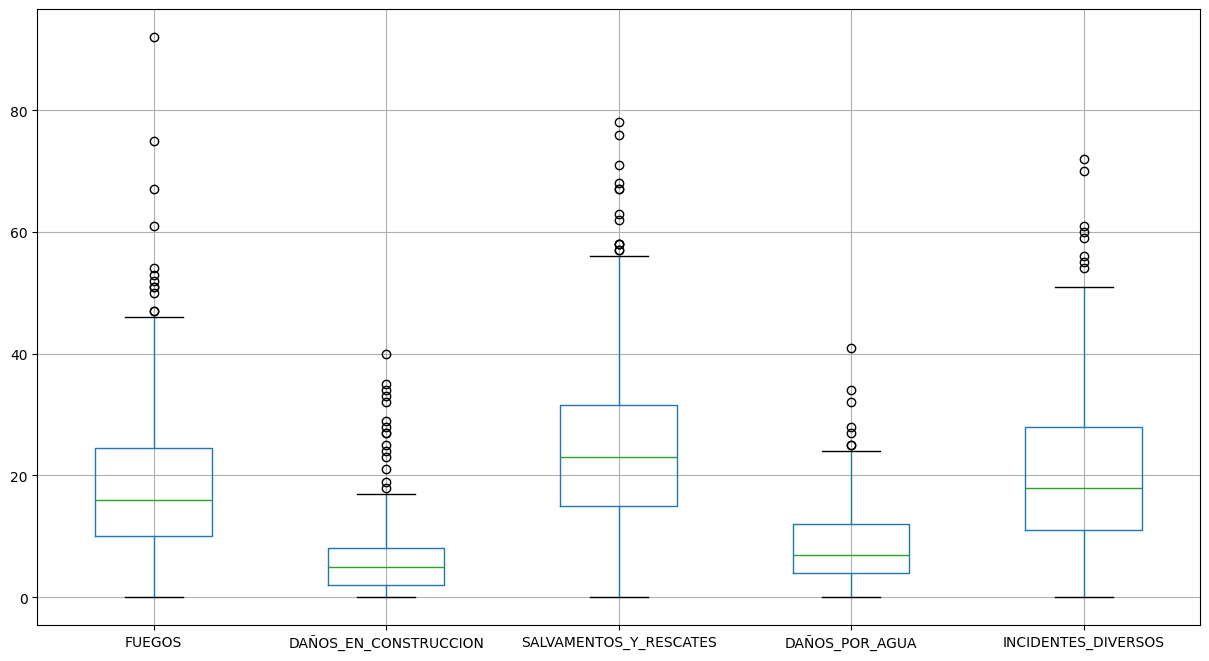

In [76]:
boxplot = pd.DataFrame.boxplot(data_loader.data['datasets/actuacionesBomberos'], column=['FUEGOS', 'DAÑOS_EN_CONSTRUCCION', 'SALVAMENTOS_Y_RESCATES','DAÑOS_POR_AGUA','INCIDENTES_DIVERSOS'], figsize=[15, 8])

In [77]:
pd.DataFrame.boxplot(data_loader.data['datasets/actuacionesBomberos'], column=['FUEGOS', 'DAÑOS_EN_CONSTRUCCION', 'SALVAMENTOS_Y_RESCATES','DAÑOS_POR_AGUA','INCIDENTES_DIVERSOS'], figsize=[15, 8])

<Axes: >

En este diagrama de cajas conjunto, podemos observar que salvamentos y rescates es el atributo con mayor dispersión (en cuanto a los límites inferiro y superior).

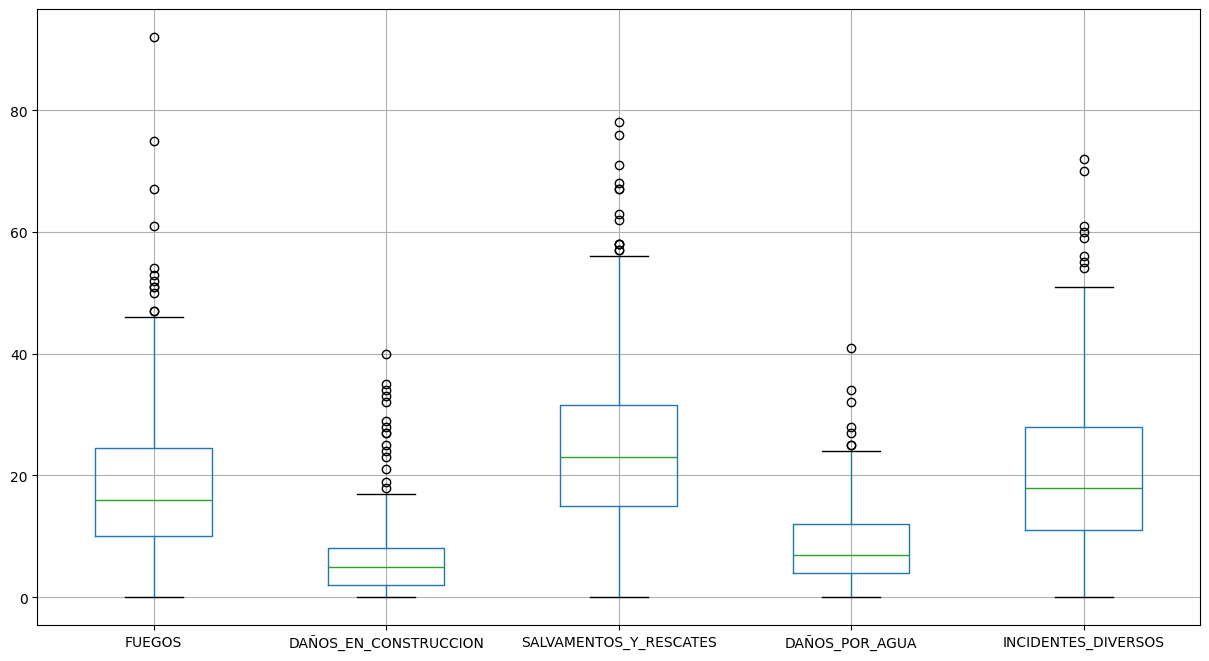

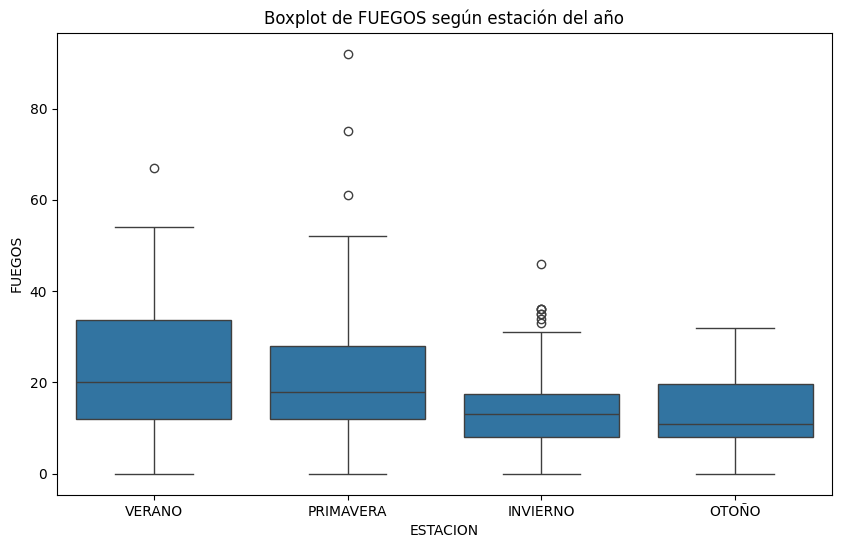

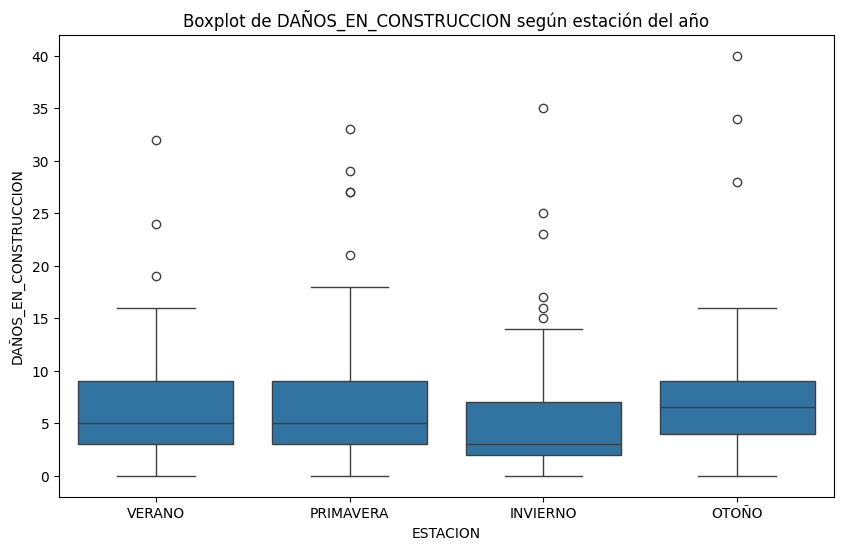

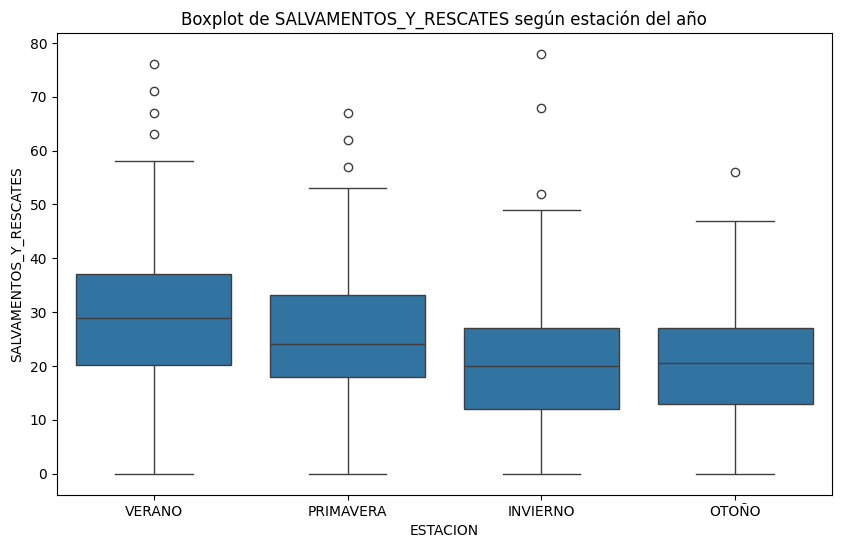

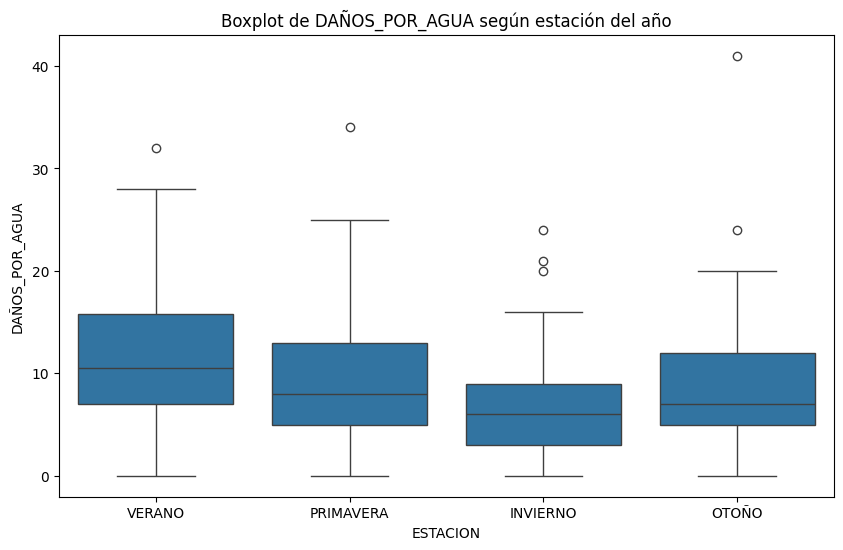

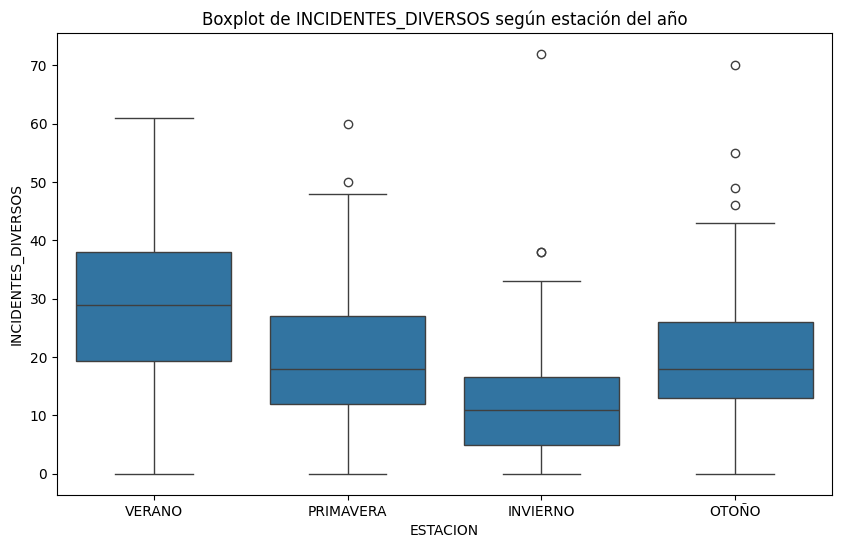

In [78]:
# Create boxplots for each column in each season
for column in tipoActuacion:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='ESTACION', y=column, data=data_loader.data['datasets/actuacionesBomberos'])
    plt.title(f'Boxplot de {column} según estación del año')
    plt.show()

In [79]:
# horas = ['HOR1', 'HOR2','HOR3', 'HOR4', 'HOR5', 'HOR6', 'HOR7', 'HOR8', 'HOR9', 'HOR10' , 'HOR11', 'HOR12', 'HOR13', 'HOR14', 'HOR15', 'HOR16', 'HOR17', 'HOR18', 'HOR19', 'HOR20', 'HOR21', 'HOR22', 'HOR23', 'HOR24']
# data_loader.data['datasets/estaciones'].plot.bar(x=horas, y=)

In [80]:
data_loader.get_info('datasets/accidentalidad')

NUM_EXPEDIENTE          0
FECHA                   0
HORA                    0
LOCALIZACION            0
NUMERO                  0
COD_DISTRITO            0
DISTRITO                0
TIPO_ACCIDENTE          0
ESTADO_METEOROLÓGICO    0
TIPO_VEHICULO           0
TIPO_PERSONA            0
RANGO_EDAD              0
SEXO                    0
COD_LESIVIDAD           0
LESIVIDAD               0
COORDENADA_X_UTM        0
COORDENADA_Y_UTM        0
POSITIVA_ALCOHOL        0
POSITIVA_DROGA          0
TIPO_DIA                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 51810
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NUM_EXPEDIENTE        195610 non-null  object        
 1   FECHA                 195610 non-null  datetime64[ns]
 2   HORA                  195610 non-null  object        
 3   LOCALIZACION          195610 non-null  object        
 4   NUM

In [81]:
data_loader.dataframe_summary('datasets/accidentalidad')

,COD_DISTRITO,COD_LESIVIDAD,POSITIVA_DROGA
count,195610.0,195610.0,195610.0
mean,9.866111,39.18335,0.003113
std,5.659225,33.437361,0.055711
min,1.0,1.0,0.0
25%,5.0,7.0,0.0
50%,10.0,14.0,0.0
75%,14.0,77.0,0.0
max,21.0,77.0,1.0
counts,195610,195610,195610
uniques,21,9,2


In [82]:
accidentes = data_loader.data['datasets/accidentalidad']
accidentes['FECHA'] = pd.to_numeric(accidentes.FECHA)

accidentes.plot(kind='scatter', x='FECHA', y='NUM_EXPEDIENTE')

<Axes: xlabel='FECHA', ylabel='NUM_EXPEDIENTE'>

In [83]:
data_loader.dataframe_summary('datasets/estaciones')

,HOR1,HOR2,HOR3,HOR4,HOR5,HOR6,HOR7,HOR8,HOR9,HOR10,...,HOR15,HOR16,HOR17,HOR18,HOR19,HOR20,HOR21,HOR22,HOR23,HOR24
count,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,...,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0,43070.0
mean,349.353866,249.446738,178.583074,143.306919,143.192686,228.891688,470.235663,770.226863,898.403065,897.940446,...,1006.635106,980.84632,959.616647,991.763594,1009.949269,987.990504,882.815997,734.660088,589.956675,462.854516
std,586.664755,435.311425,304.584859,223.363963,181.366051,253.470562,572.285139,1065.301401,1223.765007,1218.726208,...,1356.291987,1391.08328,1288.042121,1251.292668,1302.56987,1322.411338,1267.157291,1184.800883,973.216178,742.784157
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,74.0,46.0,34.0,30.0,38.0,56.0,98.0,171.0,232.0,274.0,...,333.0,303.0,308.0,334.0,344.0,335.0,290.0,223.0,162.0,118.0
50%,170.0,115.0,84.0,73.0,85.0,142.0,244.0,432.0,545.0,570.0,...,628.0,603.0,623.0,662.0,661.0,624.0,522.0,409.0,318.0,245.0
75%,378.0,264.0,195.0,158.0,179.0,323.0,625.0,1017.0,1089.0,1046.0,...,1224.0,1143.0,1138.0,1216.0,1245.0,1205.0,1032.0,815.0,672.0,533.0
max,9999.0,7854.0,9999.0,5805.0,3610.0,6234.0,5985.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9991.0,7557.0
counts,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070,...,43070,43070,43070,43070,43070,43070,43070,43070,43070,43070
uniques,2444,2060,1594,1331,1192,1386,2647,3614,3986,3948,...,3942,3833,3630,3863,3924,3843,3789,3458,3096,2682


In [84]:
data_loader.dataframe_summary('DireccionesEvolucionHistorica_20231004.csv')

,COD_VIA,COD_NDP,NÚMERO,UTMX_ED,UTMY_ED,UTMX_ETRS,UTMY_ETRS,ANGULO_ROTULACION
count,371584.0,371584.0,371584.0,371584.0,371584.0,371584.0,371584.0,371584.0
mean,2408660.396707,17547202.021718,82.853409,410801.724511,4158100.407062,410795.750303,4158870.71411,168.249326
std,7645452.207957,8153265.087079,920.868559,113546.987911,1148626.440385,113359.935326,1146960.681354,140.842409
min,127.0,11000001.0,1.0,-1.0,-1.0,0.0,0.0,0.0
25%,140400.0,11052980.75,9.0,439182.795,4471012.1575,439075.81,4470806.235,33.81
50%,391700.0,11124680.5,21.0,441199.29,4475153.785,441091.2,4474947.51,86.64
75%,630200.0,20166508.75,47.0,444273.8625,4478740.51,444167.53,4478533.905,313.35
max,31006109.0,31071551.0,61000.0,455694.4,4495761.5,455584.93,4495554.04,360.0
counts,371584,371584,371584,371584,371584,371584,371584,371584
uniques,9464,253372,2106,213909,215667,213936,215543,21844


In [85]:
data_loader.dataframe_summary('DireccionesVigentes_20231004.csv')

,COD_VIA,NUMERO,COD_NDP,DISTRITO,BARRIO,COD_POSTAL,UTMX_ED,UTMY_ED,UTMX_ETRS,UTMY_ETRS
count,210384.0,210384.0,210384.0,210384.0,210384.0,210384.0,210384.0,210384.0,210384.0,210384.0
mean,2566230.727684,81.092307,17522404.731344,11.284119,3.750076,28029.558407,442135.7702,4474320.054455,442134.074194,4475197.192623
std,7927978.567944,1051.243757,8089368.83351,5.508962,2.017848,17.168581,8130.514821,69821.113228,4326.083981,4558.477391
min,127.0,0.0,11000001.0,1.0,1.0,28001.0,-1.0,-1.0,429028.19,4462609.77
25%,119000.0,8.0,11061237.75,8.0,2.0,28019.0,439609.1125,4471677.43,439501.805,4471471.88
50%,388100.0,19.0,11127486.5,11.0,4.0,28029.0,441821.96,4475526.82,441715.2,4475320.775
75%,632000.0,43.0,20164205.75,16.0,5.0,28041.0,445062.2625,4479130.2075,444954.04,4478923.4625
max,31006072.0,61000.0,31071551.0,21.0,9.0,28925.0,455694.4,4495761.5,455584.93,4495554.04
counts,210384,210384,210384,210384,210384,210384,210384,210384,210384,210384
uniques,8479,1244,210276,21,9,62,195058,196249,195042,196143


In [86]:
data_loader.dataframe_summary('iluminacion.csv')

,NUMERO,COD_NDP,DISTRITO,BARRIO,X_UTM,Y_UTM
count,143314.0,143314.0,143314.0,143314.0,143314.0,143314.0
mean,119.636532,17734394.141124,11.162057,3.755174,44213757204460136.0,447493092091491392.0
std,1666.235208,8193175.632941,5.560175,1.973082,426131887485052.625,510396276225789.125
min,0.0,11000001.0,1.0,1.0,42900000000000000.0,446000000000000000.0
25%,7.0,11063944.25,7.0,2.0,44000000000000000.0,447000000000000000.0
50%,19.0,11130182.5,11.0,4.0,44200000000000000.0,447000000000000000.0
75%,46.0,20172613.0,16.0,5.0,44500000000000000.0,448000000000000000.0
max,61000.0,31068924.0,21.0,9.0,45500000000000000.0,449000000000000000.0
counts,143314,143314,143314,143314,143314,143314
uniques,787,109999,21,9,27,4


In [87]:
data_loader.dataframe_summary('padron22.csv')

,Ï»¿EJERICIO,COD_DISTRITO,COD_BARRIO,CUOTA,CONTADOR
count,180345.0,180345.0,180345.0,180345.0,180345.0
mean,2022.0,9.889379,99.822352,81.910516,10.069434
std,0.0,5.90113,60.665245,67.361971,77.008243
min,2022.0,0.0,0.0,0.0,1.0
25%,2022.0,5.0,51.0,20.0,1.0
50%,2022.0,9.0,95.0,59.0,2.0
75%,2022.0,15.0,152.0,129.0,5.0
max,2022.0,21.0,215.0,266.0,7862.0
counts,180345,180345,180345,180345,180345
uniques,1,22,132,32,708


In [88]:
data_loader.dataframe_summary('RADARES_FIJOS_vDTT.csv')

,Nº\nRADAR
count,29.0
mean,15.0
std,8.514693
min,1.0
25%,8.0
50%,15.0
75%,22.0
max,29.0
counts,29
uniques,29


In [89]:
data_loader.dataframe_summary('VialesEvolucionHistorica_20231004.csv')

,COD_VIA,VIA_SQC
count,16446.0,16446.0
mean,4175345.431655,1.312842
std,10082926.753856,0.668149
min,125.0,1.0
25%,172206.25,1.0
50%,470175.0,1.0
75%,733057.5,1.0
max,99000000.0,13.0
counts,16446,16446
uniques,12554,13


In [90]:
data_loader.dataframe_summary('VialesVigentesDistritosBarrios_20231004.csv')

,COD_VIA,DISTRITO,BARRIO
count,11014.0,10990.0,10990.0
mean,4248101.971128,11.142493,3.605732
std,10196393.711887,5.739252,2.068502
min,127.0,1.0,0.0
25%,121825.0,7.0,2.0
50%,434000.0,11.0,3.0
75%,704068.75,16.0,5.0
max,31006183.0,21.0,9.0
counts,11014,10990,10990
uniques,9354,21,10


In [91]:
data_loader.dataframe_summary('VialesVigentesDistritos_20231004.csv')

,COD_VIA,DISTRITO
count,9839.0,9815.0
mean,4146937.609716,11.178502
std,10079147.61775,5.745088
min,127.0,1.0
25%,122475.0,7.0
50%,434650.0,11.0
75%,703150.0,16.0
max,31006183.0,21.0
counts,9839,9815
uniques,9354,21


In [92]:
data_loader.dataframe_summary('VialesVigentes_20231004.csv')

,COD_VIA,COD_VIA_COMIENZA,COD_VIA_TERMINA
count,9388.0,9388.0,9388.0
mean,4042814.759906,3466096.384001,8018823.443012
std,9961522.633361,11504118.496724,22587878.066217
min,127.0,127.0,127.0
25%,118493.75,139028.75,141550.0
50%,429850.0,419000.0,440375.0
75%,698962.5,667800.0,713200.0
max,31006183.0,99000003.0,99000003.0
counts,9388,9388,9388
uniques,9354,3446,3821



Tabla de frecuencia relativa de accidentes por distritos. En esta tabla se obtiene la frecuencia de accidentes en todos los distritos de madrid, esto hace que se pueda obtener también el tráfico de coches en el distrito. Aunque no sea una relación proporcional, a mayor número de accidentes supone un tráfico mayor en la zona.

/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/3339958787.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(aux_df.index, rotation=90)


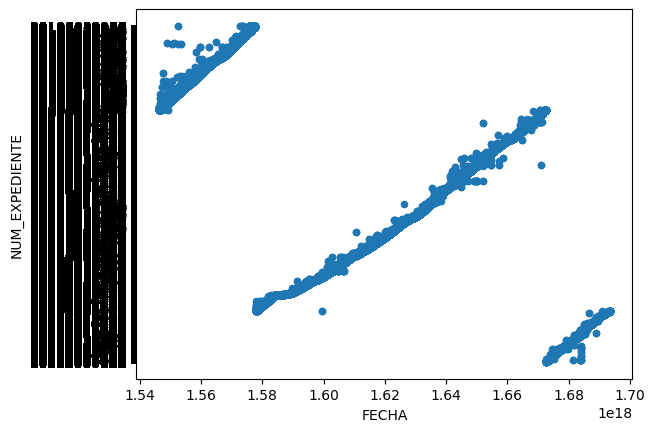

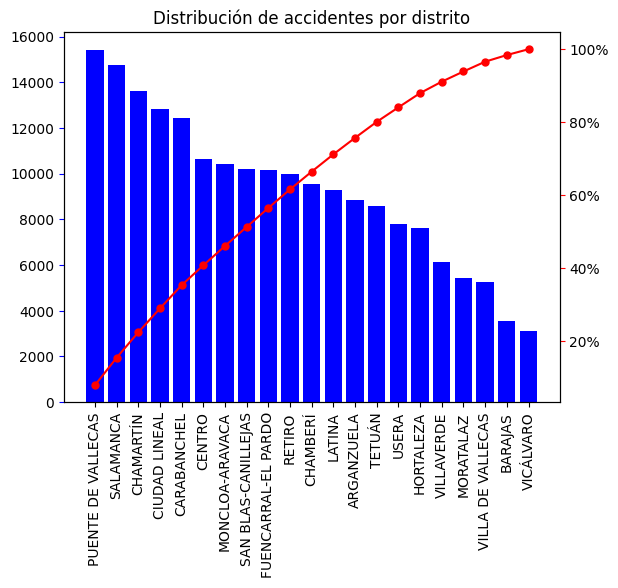

In [93]:
data_loader.data['datasets/accidentalidad']['DISTRITO'] = data_loader.data['datasets/accidentalidad']['DISTRITO'].astype(str)
CSVDataLoader.create_graph(data_loader.data['datasets/accidentalidad'], 'DISTRITO', 'accidentes por distrito')

Tabla comparativa que muestra los accidentes donde la persona que lo ha padecido ha dado positivo en alcohol.

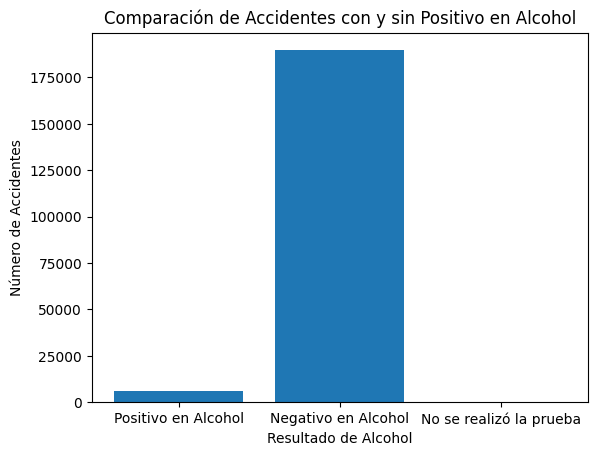

In [94]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'S']
negativos = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'N']
labels = ['Positivo en Alcohol', 'Negativo en Alcohol', 'No se realizó la prueba']
values = [len(positivos), len(negativos), len(accidentes) - len(positivos) - len(negativos)]
plt.bar(labels, values)
plt.xlabel('Resultado de Alcohol')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Alcohol')
plt.show()

Tabla comparativo donde la persona que ha padecido el accidente ha dado positivo en drogas.

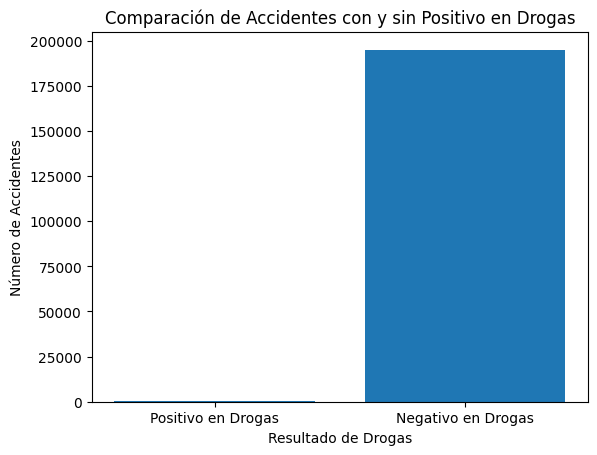

In [95]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos = accidentes[accidentes['POSITIVA_DROGA'] == 1]
negativos = accidentes[accidentes['POSITIVA_DROGA'] == 0]
labels = ['Positivo en Drogas', 'Negativo en Drogas']
values = [len(positivos), len(negativos)]
plt.bar(labels, values)
plt.xlabel('Resultado de Drogas')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Drogas')
plt.show()

Tabla comparativa que relaciona los accidente en los que la persona ha dado positivo en alcohol y drogas

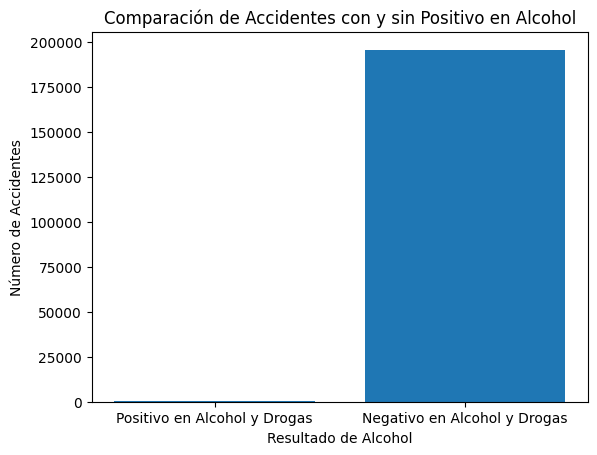

In [96]:
accidentes = data_loader.data['datasets/accidentalidad']
positivos_alcohol = accidentes[accidentes['POSITIVA_ALCOHOL'] == 'S']
positivos_drogas = accidentes[accidentes['POSITIVA_DROGA'] == 1]
positivos_alcohol_drogas = positivos_alcohol[positivos_alcohol['POSITIVA_DROGA'] == 1]
positivos_alcohol_drogas = len(positivos_alcohol_drogas)
negativos = len(accidentes) - positivos_alcohol_drogas
labels = ['Positivo en Alcohol y Drogas', 'Negativo en Alcohol y Drogas']
values = [positivos_alcohol_drogas, negativos]
plt.bar(labels, values)
plt.xlabel('Resultado de Alcohol')
plt.ylabel('Número de Accidentes')
plt.title('Comparación de Accidentes con y sin Positivo en Alcohol')
plt.show()

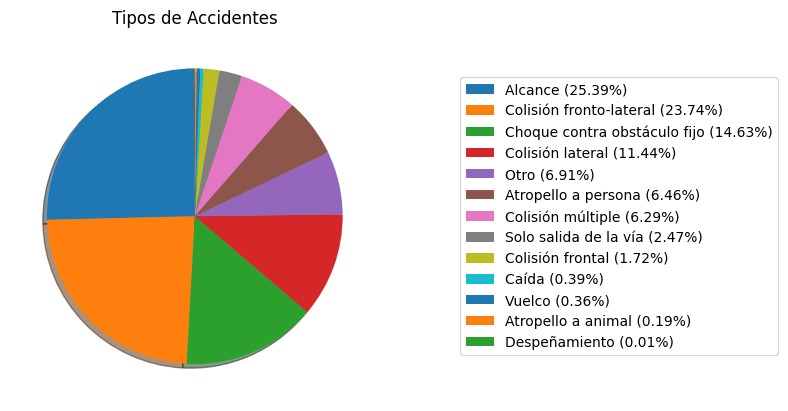

In [97]:
accidentes = data_loader.data['datasets/accidentalidad']
labels = accidentes['TIPO_ACCIDENTE'].unique()
# La siguiente línea eliminaba el valor 13.0 del gráfico antes de tener la solución definitiva en la limpieza actual
# labels = np.delete(labels, obj=13, axis=0)

values = accidentes['TIPO_ACCIDENTE'].value_counts()

percentages = (values / len(accidentes)) * 100

plt.pie(values, shadow=True, startangle=90)
plt.title('Tipos de Accidentes')
legend_labels = [f'{label} ({percentage:.2f}%)' for label, percentage in zip(labels, percentages)]
plt.legend(labels=legend_labels, loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.show()

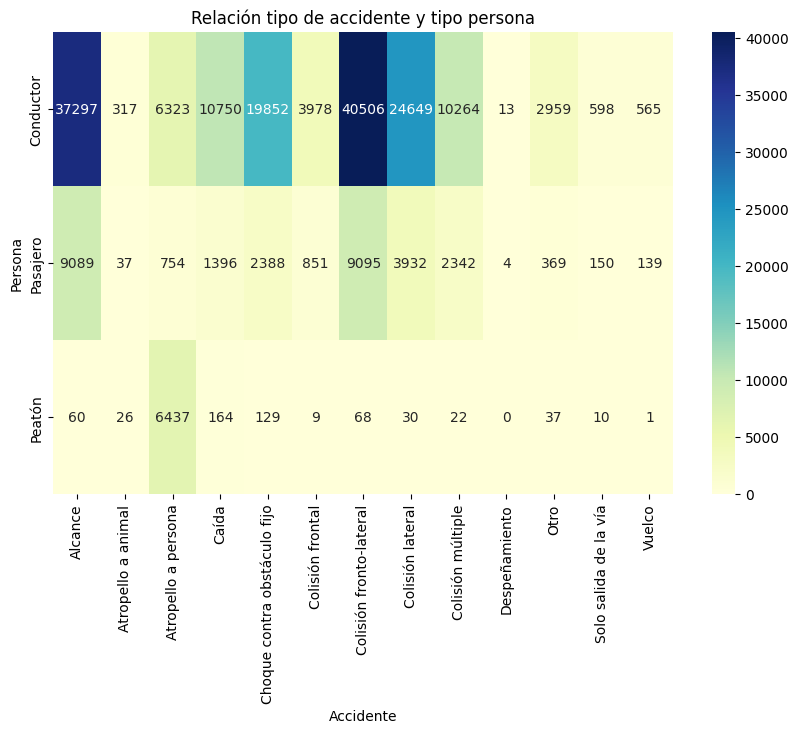

In [98]:
# Create a cross-tabulation of TIPO_PERSONA and TIPO_ACCIDENTE
cross_tab = pd.crosstab(accidentes['TIPO_PERSONA'], accidentes['TIPO_ACCIDENTE'])

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Relación tipo de accidente y tipo persona')
plt.xlabel('Accidente')
plt.ylabel('Persona')

plt.show()

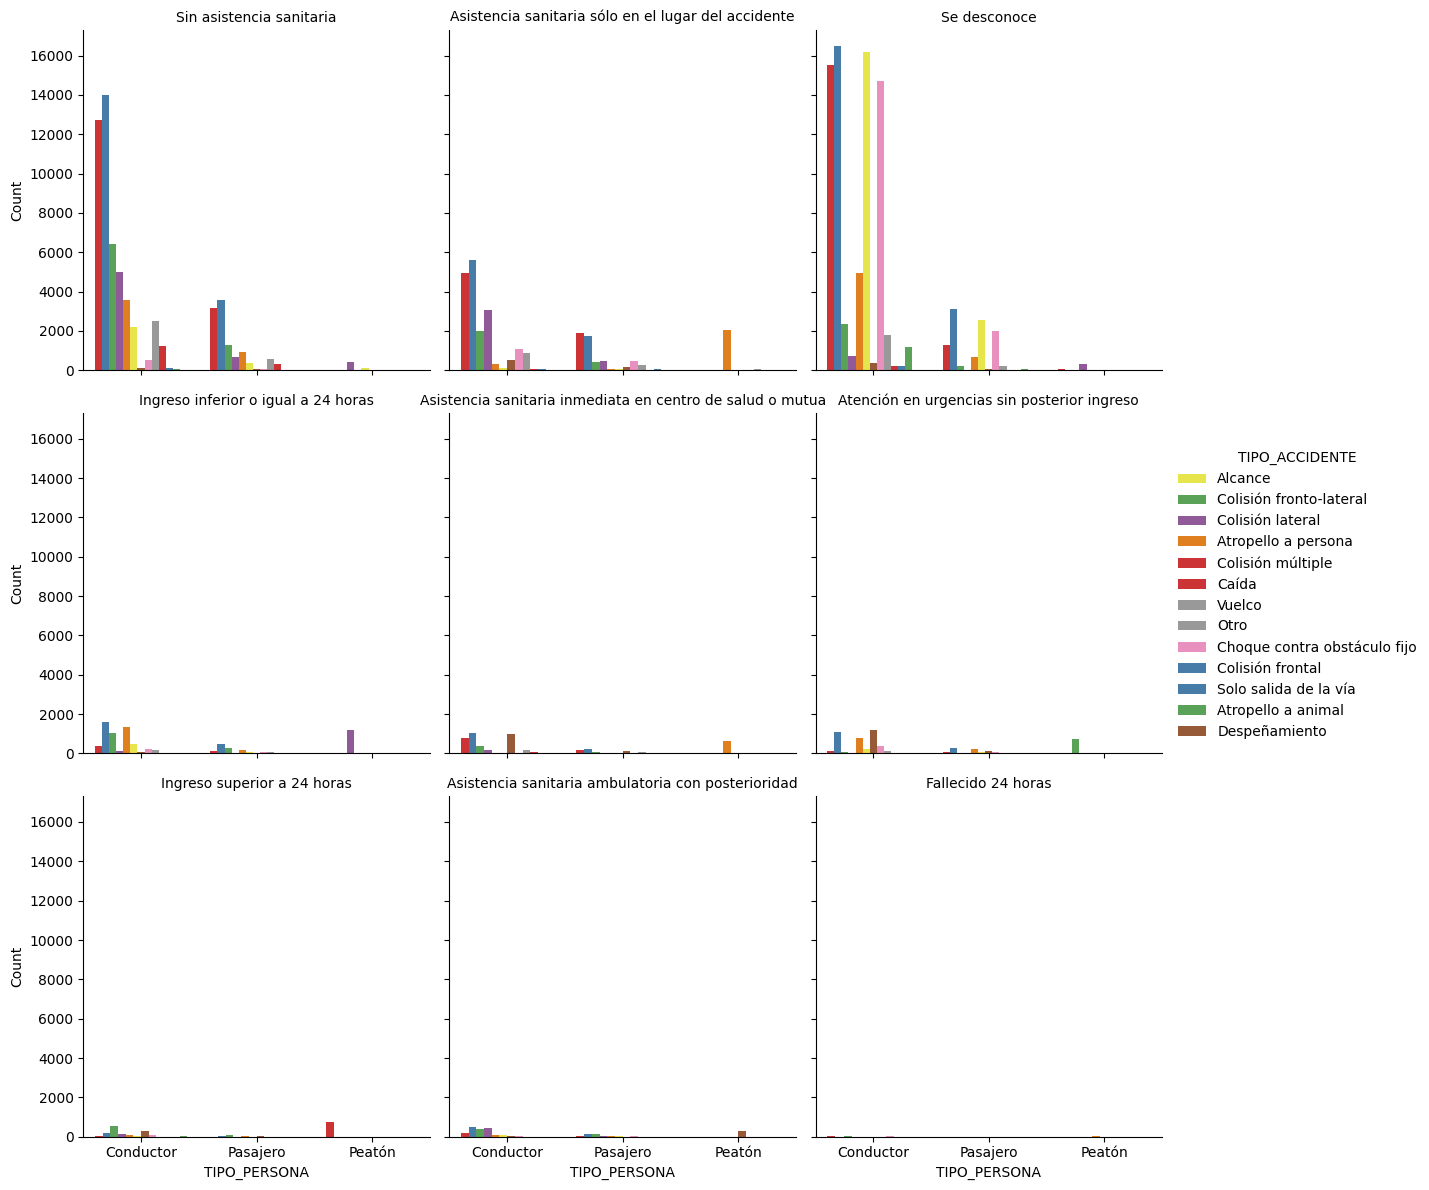

In [99]:
# Create a faceted plot
g = sns.FacetGrid(accidentes, col='LESIVIDAD', height=4, col_wrap=3)
g.map_dataframe(sns.countplot, x='TIPO_PERSONA', hue='TIPO_ACCIDENTE', palette='Set1')
g.set_axis_labels('TIPO_PERSONA', 'Count')
g.set_titles(col_template='{col_name}')

# Add a legend
g.add_legend(title='TIPO_ACCIDENTE')

plt.show()

/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/2814729789.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(wrapped_labels)


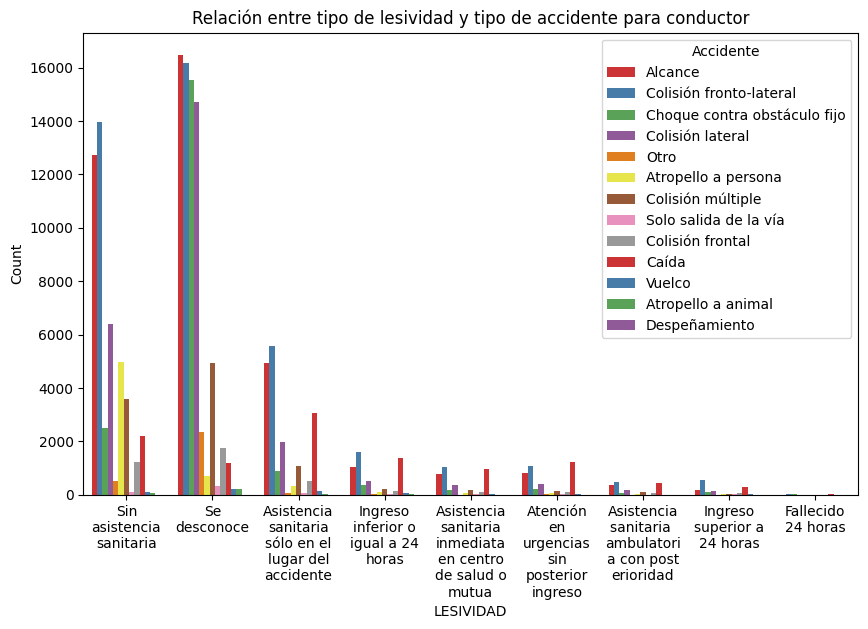

In [100]:
# Filter the DataFrame for cases where TIPO_PERSONA is 'Driver'
df_driver = accidentes[accidentes['TIPO_PERSONA'] == 'Conductor']

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=df_driver, x='LESIVIDAD', hue='TIPO_ACCIDENTE', palette='Set1')

# Wrap the x-axis labels
wrapped_labels = [textwrap.fill(label.get_text(), 10) for label in plot.get_xticklabels()]
plot.set_xticklabels(wrapped_labels)

plt.title('Relación entre tipo de lesividad y tipo de accidente para conductor')
plt.xlabel('LESIVIDAD')
plt.ylabel('Count')
plt.legend(title='Accidente')

plt.show()

/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/480348612.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(wrapped_labels)


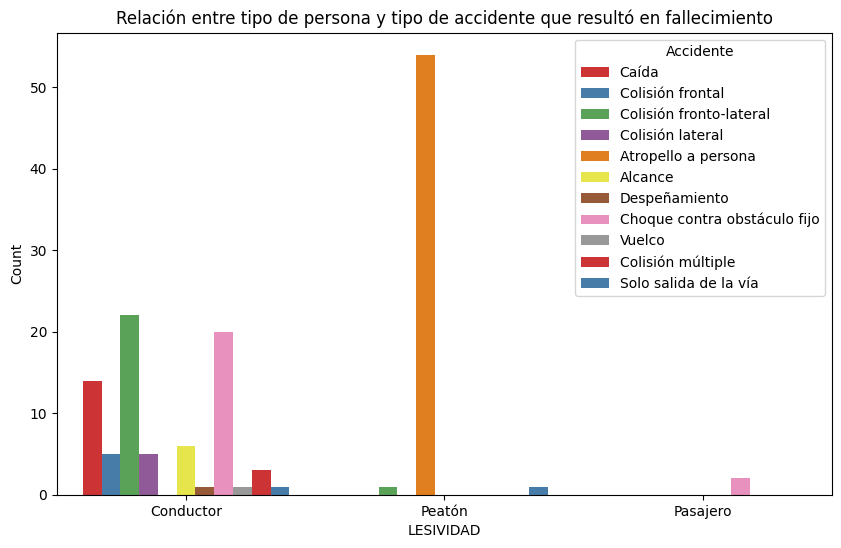

In [101]:
df_dead = accidentes[accidentes['COD_LESIVIDAD'] == 4]

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
plot = sns.countplot(data=df_dead, x='TIPO_PERSONA', hue='TIPO_ACCIDENTE', palette='Set1')

# Wrap the x-axis labels
wrapped_labels = [textwrap.fill(label.get_text(), 10) for label in plot.get_xticklabels()]
plot.set_xticklabels(wrapped_labels)

plt.title('Relación entre tipo de persona y tipo de accidente que resultó en fallecimiento')
plt.xlabel('LESIVIDAD')
plt.ylabel('Count')
plt.legend(title='Accidente')

plt.show()

/var/folders/lw/9l9d_kvs6pn9gnwyjsn35qlw0000gn/T/ipykernel_30188/1956786289.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_peaton, x='ESTADO_METEOROLÓGICO', palette='dark')


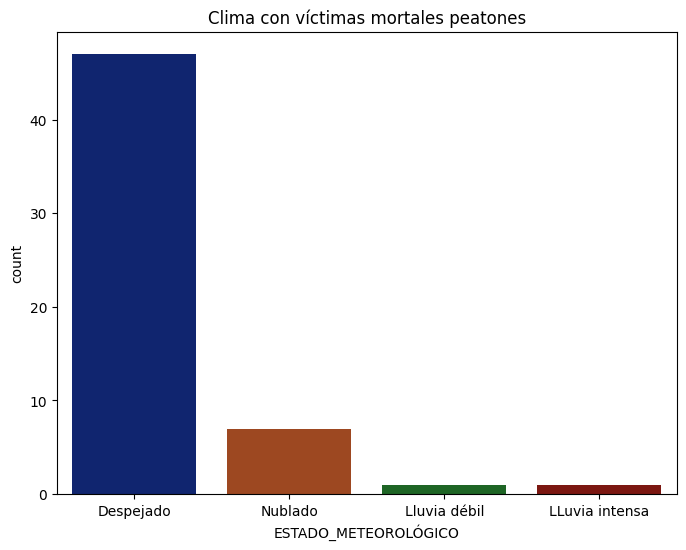

In [102]:
df_peaton = accidentes[(accidentes['TIPO_PERSONA'] == 'Peatón') & (accidentes['COD_LESIVIDAD'] == 4)]

# Plot the count of ESTADO_METEOROLOGICO
plt.figure(figsize=(8, 6))
sns.countplot(data=df_peaton, x='ESTADO_METEOROLÓGICO', palette='dark')
plt.title('Clima con víctimas mortales peatones')
plt.show()

In [103]:
estaciones = data_loader.data['datasets/estaciones']


In [104]:
direccionesvigentes = data_loader.data['DireccionesVigentes_20231004.csv']

In [105]:
data_loader.get_info('padron22.csv')

Ï»¿EJERICIO                 0
COD_TIPO_PERSONA            0
TIPO_PERSONA                0
COD_DISTRITO                0
DISTRITO                    0
COD_BARRIO                  0
BARRIO                      0
COD_TIPO_VEHÃCULO          0
TIPO_VEHÃCULO              0
ETIQUETA_MEDIOAMBIENTAL     0
CLASIFICACIÃN_AMBIENTAL    0
CUOTA                       0
TIPO_CARBURANTE             0
AÃO_MATRICULACIÃN         0
CONTADOR                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180345 entries, 0 to 180344
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Ï»¿EJERICIO               180345 non-null  int64  
 1   COD_TIPO_PERSONA          180345 non-null  object 
 2   TIPO_PERSONA              180345 non-null  object 
 3   COD_DISTRITO              180345 non-null  int64  
 4   DISTRITO                  180345 non-null  object 
 5   COD_BARRIO                180

In [106]:
data_loader.data['padron22.csv'] = data_loader.data['padron22.csv'].rename(columns={'TIPO_VEHÃCULO': 'TIPO_VEHICULO'})
data_loader.data['padron22.csv'] = data_loader.data['padron22.csv'].rename(columns={'COD_TIPO_VEHÃCULO': 'COD_TIPO_VEHICULO'})

padron = data_loader.data['padron22.csv']
print(data_loader.data['padron22.csv']['COD_TIPO_VEHICULO'].unique())



['CA' 'MT' 'RE' 'TR' 'TU' 'CI' 'AU' 'SE']


Este gráfico muestra los distintos tipos de accidentes registrados. Se puede ver que la colisión frontal-lateral y el alcance son las mauores causas de accidentes.

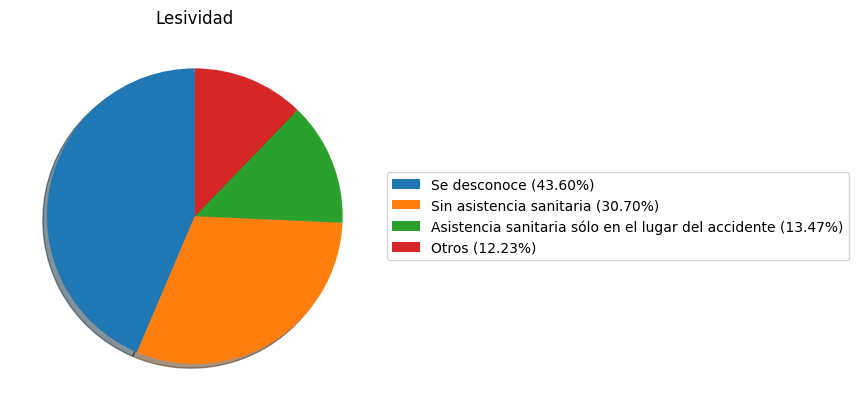

In [133]:
accidentes = data_loader.data['datasets/accidentalidad']
values = accidentes['LESIVIDAD'].value_counts()
labels = values.index
percentages = (values / len(accidentes)) * 100
umbral = 5
categorias_otras = labels[percentages < umbral]
values['Otros'] = values[percentages < umbral].sum()
values = values.drop(index=categorias_otras)
percentages = (values / len(accidentes)) * 100
plt.pie(values, shadow=True, startangle=90)
plt.title('Lesividad')
legend_labels = [f'{label} ({percentage:.2f}%)' for label, percentage in zip(values.index, percentages)]
plt.legend(labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

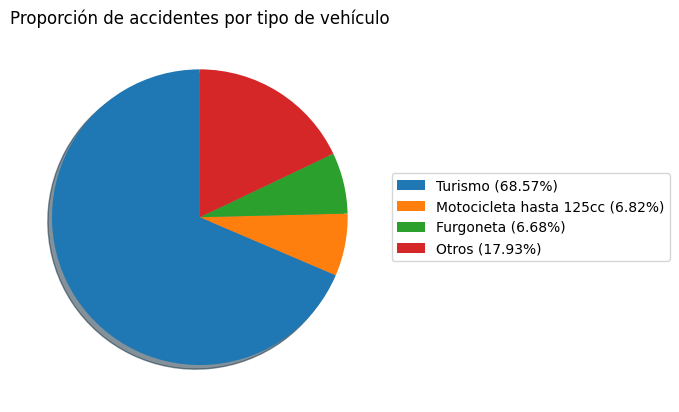

In [135]:
accidentes = data_loader.data['datasets/accidentalidad']
values = accidentes['TIPO_VEHICULO'].value_counts()
labels = values.index
percentages = (values / len(accidentes)) * 100
umbral = 5
categorias_otras = labels[percentages < umbral]
values['Otros'] = values[percentages < umbral].sum()
values = values.drop(index=categorias_otras)
percentages = (values / len(accidentes)) * 100
plt.pie(values, shadow=True, startangle=90)
plt.title('Proporción de accidentes por tipo de vehículo')
legend_labels = [f'{label} ({percentage:.2f}%)' for label, percentage in zip(values.index, percentages)]
plt.legend(labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

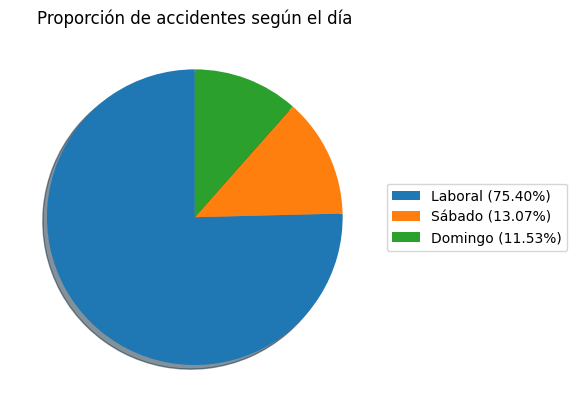

In [137]:
accidentes = data_loader.data['datasets/accidentalidad']
values = accidentes['TIPO_DIA'].value_counts()
labels = values.index
percentages = (values / len(accidentes)) * 100
plt.pie(values, shadow=True, startangle=90)
plt.title('Proporción de accidentes según el día')
legend_labels = [f'{label} ({percentage:.2f}%)' for label, percentage in zip(labels, percentages)]
plt.legend(labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [108]:
data_loader.get_info('iluminacion.csv')

TIPO_BLOQUE       0
TIPO              0
VIA_CLASE         0
VIA_PAR        2919
VIA_NOMBRE        0
CLASE_APP         0
NUMERO            0
COD_NDP           0
DISTRITO          0
BARRIO            0
X_UTM             0
Y_UTM             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 143314 entries, 0 to 233305
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TIPO_BLOQUE  143314 non-null  object 
 1   TIPO         143314 non-null  object 
 2   VIA_CLASE    143314 non-null  object 
 3   VIA_PAR      140395 non-null  object 
 4   VIA_NOMBRE   143314 non-null  object 
 5   CLASE_APP    143314 non-null  object 
 6   NUMERO       143314 non-null  int64  
 7   COD_NDP      143314 non-null  int64  
 8   DISTRITO     143314 non-null  int64  
 9   BARRIO       143314 non-null  int64  
 10  X_UTM        143314 non-null  float64
 11  Y_UTM        143314 non-null  float64
dtypes: float64(2), int64(4), object(6)

In [109]:

def convert_to_latlon(row):
    try:
        easting = float(row['COORDENADA_X_UTM'].replace(',', '.'))
        northing = float(row['COORDENADA_Y_UTM'].replace(',', '.'))
        return utm.to_latlon(easting, northing, zone_number=30, zone_letter='T')
    except (ValueError, AttributeError):
        return None, None
accidentes['LAT'], accidentes['LONG'] = zip(*accidentes.apply(convert_to_latlon, axis=1))

In [110]:
data_loader.get_info('iluminacion.csv')

TIPO_BLOQUE       0
TIPO              0
VIA_CLASE         0
VIA_PAR        2919
VIA_NOMBRE        0
CLASE_APP         0
NUMERO            0
COD_NDP           0
DISTRITO          0
BARRIO            0
X_UTM             0
Y_UTM             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 143314 entries, 0 to 233305
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TIPO_BLOQUE  143314 non-null  object 
 1   TIPO         143314 non-null  object 
 2   VIA_CLASE    143314 non-null  object 
 3   VIA_PAR      140395 non-null  object 
 4   VIA_NOMBRE   143314 non-null  object 
 5   CLASE_APP    143314 non-null  object 
 6   NUMERO       143314 non-null  int64  
 7   COD_NDP      143314 non-null  int64  
 8   DISTRITO     143314 non-null  int64  
 9   BARRIO       143314 non-null  int64  
 10  X_UTM        143314 non-null  float64
 11  Y_UTM        143314 non-null  float64
dtypes: float64(2), int64(4), object(6)

In [111]:
import geopandas as gpd
from shapely.geometry import Point

# Assuming your DataFrame is named accidentes
# If your DataFrame is named differently, replace accidentes with your DataFrame's name
iluminacion = data_loader.data['iluminacion.csv']

decimals = 6

# Round the values in 'X_UTM' and 'Y_UTM' columns
iluminacion['X_UTM'] = iluminacion['X_UTM'].round(decimals)
iluminacion['Y_UTM'] = iluminacion['Y_UTM'].round(decimals)

# Convert UTM coordinates to GeoDataFrame
geometry = [Point(easting, northing) for easting, northing in zip(iluminacion['X_UTM'], iluminacion['Y_UTM'])]
gdf = gpd.GeoDataFrame(iluminacion, geometry=geometry, crs="EPSG:32630") 

# Define valid bounding box
valid_easting_range = (100000, 999999)
valid_northing_range = (0, 10000000)  # Assuming a reasonable northing range, adjust if needed

# Filter out-of-range points
filtered_gdf = gdf.cx[valid_easting_range[0]:valid_easting_range[1], valid_northing_range[0]:valid_northing_range[1]]

# Convert back to original DataFrame
f = filtered_gdf.drop(columns='geometry')

# Display the updated DataFrame
print(f.head())


Empty DataFrame
Columns: [TIPO_BLOQUE, TIPO, VIA_CLASE, VIA_PAR, VIA_NOMBRE, CLASE_APP, NUMERO, COD_NDP, DISTRITO, BARRIO, X_UTM, Y_UTM]
Index: []


In [112]:
iluminacion.head()

,TIPO_BLOQUE,TIPO,VIA_CLASE,VIA_PAR,VIA_NOMBRE,CLASE_APP,NUMERO,COD_NDP,DISTRITO,BARRIO,X_UTM,Y_UTM
0,LBE003,DESCARGA,CARRETERA,DE,EL PARDO A COLMENAR VIEJO,NUMERO,13,31044797,8,1,4.340000e+16,4.490000e+17
2,LBE003,DESCARGA,CARRETERA,DE,EL PARDO A COLMENAR VIEJO,NUMERO,11,31044796,8,1,4.340000e+16,4.490000e+17
5,LBE003,DESCARGA,CARRETERA,DE,EL PARDO A COLMENAR VIEJO,NUMERO,94,31044798,8,1,4.340000e+16,4.490000e+17
7,FVLED002,LED,CALLE,DEL,ESCUADRON,NUMERO,10,11043030,8,1,4.340000e+16,4.490000e+17
8,FVLED002,LED,CALLE,DEL,ESCUADRON,NUMERO,6,11043029,8,1,4.340000e+16,4.490000e+17


In [113]:
#iluminacion['LAT'], iluminacion['LONG'] = zip(*iluminacion.apply(lambda row: utm.to_latlon(float(row['X_UTM']), float(row['Y_UTM']), zone_number=30, zone_letter='T'), axis=1))

In [114]:
data_loader.get_info('datasets/accidentalidad')

NUM_EXPEDIENTE              0
FECHA                       0
HORA                        0
LOCALIZACION                0
NUMERO                      0
COD_DISTRITO                0
DISTRITO                    0
TIPO_ACCIDENTE              0
ESTADO_METEOROLÓGICO        0
TIPO_VEHICULO               0
TIPO_PERSONA                0
RANGO_EDAD                  0
SEXO                        0
COD_LESIVIDAD               0
LESIVIDAD                   0
COORDENADA_X_UTM            0
COORDENADA_Y_UTM            0
POSITIVA_ALCOHOL            0
POSITIVA_DROGA              0
TIPO_DIA                    0
LAT                     29929
LONG                    29929
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 51810
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NUM_EXPEDIENTE        195610 non-null  object 
 1   FECHA                 195610 non-null  int64  
 2   HORA     

In [115]:
47039/195605

0.24047953784412465

In [116]:
# Assuming your DataFrame is named accidentes
# If your DataFrame is named differently, replace accidentes with your DataFrame's name

# Check occurrences of '#¡VALOR!' in 'COORDENADA_X_UTM' column
valor_occurrences_x = data_loader.data['datasets/accidentalidad'][data_loader.data['datasets/accidentalidad']['COORDENADA_X_UTM'] == '#¡VALOR!']

# Check occurrences of '#¡VALOR!' in 'COORDENADA_Y_UTM' column
valor_occurrences_y = data_loader.data['datasets/accidentalidad'][data_loader.data['datasets/accidentalidad']['COORDENADA_Y_UTM'] == '#¡VALOR!']

# Display the occurrences
print(len(valor_occurrences_x))
print(len(valor_occurrences_y))
print("Occurrences in COORDENADA_X_UTM:")
print(valor_occurrences_x)

print("\nOccurrences in COORDENADA_Y_UTM:")
print(valor_occurrences_y)


30
30
Occurrences in COORDENADA_X_UTM:
      NUM_EXPEDIENTE                FECHA      HORA  \
17953    2020S011111  1596931200000000000  18:10:00   
17954    2020S011111  1596931200000000000  18:10:00   
17955    2020S011111  1596931200000000000  18:10:00   
20493    2020S012560  1599955200000000000  17:45:00   
20494    2020S012560  1599955200000000000  17:45:00   
20495    2020S012560  1599955200000000000  17:45:00   
30817    2021S018891  1634428800000000000  12:20:00   
30818    2021S018891  1634428800000000000  12:20:00   
37939    2021S022950  1638489600000000000   6:30:00   
37940    2021S022950  1638489600000000000   6:30:00   
39443    2021S023850  1639440000000000000   9:10:00   
39444    2021S023850  1639440000000000000   9:10:00   
39445    2021S023850  1639440000000000000   9:10:00   
41231    2021S024803  1640563200000000000   2:10:00   
41425    2021S024915  1640736000000000000   0:00:00   
41524    2021S024959  1640736000000000000  13:55:00   
41614    2021S024999  1640

In [117]:
data_loader.get_info('datasets/accidentalidad')

NUM_EXPEDIENTE              0
FECHA                       0
HORA                        0
LOCALIZACION                0
NUMERO                      0
COD_DISTRITO                0
DISTRITO                    0
TIPO_ACCIDENTE              0
ESTADO_METEOROLÓGICO        0
TIPO_VEHICULO               0
TIPO_PERSONA                0
RANGO_EDAD                  0
SEXO                        0
COD_LESIVIDAD               0
LESIVIDAD                   0
COORDENADA_X_UTM            0
COORDENADA_Y_UTM            0
POSITIVA_ALCOHOL            0
POSITIVA_DROGA              0
TIPO_DIA                    0
LAT                     29929
LONG                    29929
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 195610 entries, 0 to 51810
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NUM_EXPEDIENTE        195610 non-null  object 
 1   FECHA                 195610 non-null  int64  
 2   HORA     

Este gráfico muestra el tipo de lesividad del accidente. Se aprecia que 3 de cada 4 personas no necesitan asistencia sanitaria.